In [96]:
import pandas as pd
import numpy as np

# Number of mock entries
num_entries = 10000

# Generate random data
np.random.seed(42)  # For reproducibility
user_ids = np.random.randint(1, 101, num_entries)
num_bets = np.random.randint(2, 7, num_entries)  # Number of bets in each parlay (2 to 6)
bet_amounts = np.round(np.random.uniform(10, 500, num_entries), 2)

# Create a DataFrame
df_mock = pd.DataFrame({
    'User_ID': user_ids,
    'Num_Bets': num_bets,
    'Bet_Amount': bet_amounts
})

# Function to generate random American odds from a predefined set
def generate_random_odds(num_bets):
    predefined_odds = [-500, -450, -400, -200, -150, -120, -105, 100, 105, 110, 115, 180, 220, 300, 400, 500]
    strategy = np.random.choice(['all_favorites', 'all_underdogs', 'mix'], p=[0.2, 0.2, 0.6])
    
    if strategy == 'all_favorites':
        odds = np.random.choice([odd for odd in predefined_odds if odd < 0], num_bets)
    elif strategy == 'all_underdogs':
        odds = np.random.choice([odd for odd in predefined_odds if odd > 0], num_bets)
    else:  # mix
        odds = np.random.choice(predefined_odds, num_bets)
    
    return odds

# Apply the function to generate random odds for each entry
df_mock['Odds'] = df_mock['Num_Bets'].apply(generate_random_odds)

# Function to convert American odds to implied probability
def american_to_implied_probability(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Calculate implied probabilities for each bet
df_mock['Implied_Probabilities'] = df_mock['Odds'].apply(lambda x: [american_to_implied_probability(odd) for odd in x])

# Function to calculate combined implied probability and combined odds
def calculate_combined_odds(implied_probabilities):
    combined_probability = np.prod(implied_probabilities)
    combined_odds = 1 / combined_probability if combined_probability != 0 else np.inf
    return combined_probability, combined_odds

# Apply the function to calculate combined implied probability and combined odds
df_mock[['Combined_Probability', 'Combined_Odds']] = df_mock['Implied_Probabilities'].apply(lambda x: pd.Series(calculate_combined_odds(x)))

# Function to calculate the vig
def calculate_vig(implied_probabilities):
    total_implied_probability = sum(implied_probabilities)
    vig = total_implied_probability - 1
    return vig

# Apply the function to calculate the vig for each entry
df_mock['Vig'] = df_mock['Implied_Probabilities'].apply(calculate_vig)

# Function to determine the outcome based on combined probability
def determine_outcome(probability):
    return np.random.choice(['Win', 'Loss'], p=[probability, 1 - probability])

# Apply the function to determine the outcome for each entry
df_mock['Overall_Result'] = df_mock['Combined_Probability'].apply(determine_outcome)

# Calculate payouts and profits based on the overall result
def calculate_payout(row):
    if row['Overall_Result'] == 'Win':
        return row['Bet_Amount'] * row['Combined_Odds']
    else:
        return 0

def calculate_profit(row):
    commission = row['Bet_Amount'] * 0.10  # 10% commission fee
    return row['Payout'] - row['Bet_Amount'] + commission

# Apply the functions to calculate payouts and profits
df_mock['Payout'] = df_mock.apply(calculate_payout, axis=1)
df_mock['Profit'] = df_mock.apply(calculate_profit, axis=1)
df_mock['Commission'] = df_mock['Bet_Amount'] * 0.10  # Add commission column

# Calculate average vig and average combined odds
average_vig = df_mock['Vig'].mean()
average_combined_odds = df_mock['Combined_Odds'].mean()

print(f"Average Vig: {average_vig}")
print(f"Average Combined Odds: {average_combined_odds}")

# Define the file name
file_name = 'mock_betting_data.csv'

# Export the DataFrame to CSV in the current directory
df_mock.to_csv(file_name, index=False)

print(f"DataFrame exported to {file_name} in the current directory")

Average Vig: 1.026489198348447
Average Combined Odds: 125.37828898118865
DataFrame exported to mock_betting_data.csv in the current directory


         Total_Bets  Total_Amount_Bet  Average_Bet_Amount  Total_Profit  Wins  \
User_ID                                                                         
1                97          27256.65          280.996392  19340.162717    15   
2               110          28384.21          258.038273   1104.144627    12   
3                99          27520.74          277.987273  -2832.340841    16   
4               103          25456.06          247.146214 -10944.969353    15   
5                87          24612.14          282.898161 -13429.090964     9   

         Losses  Win_Loss_Ratio  
User_ID                          
1            82        0.182927  
2            98        0.122449  
3            83        0.192771  
4            88        0.170455  
5            78        0.115385  


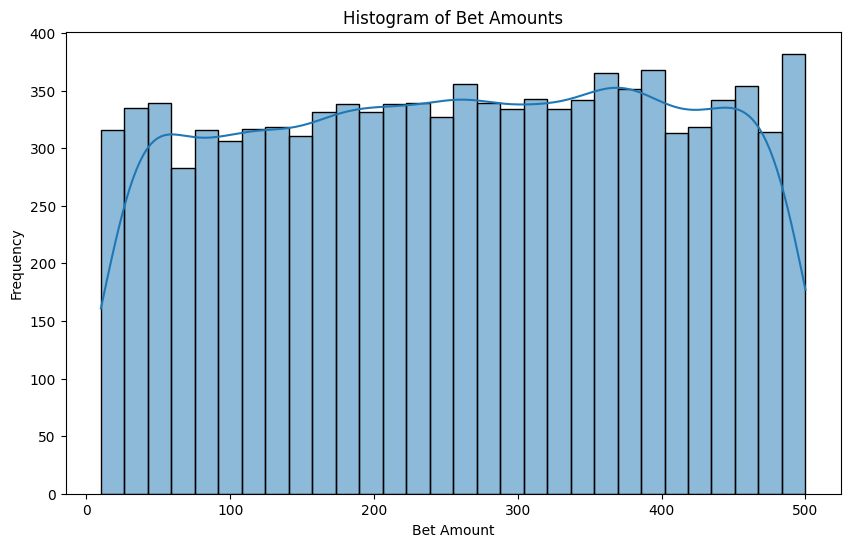

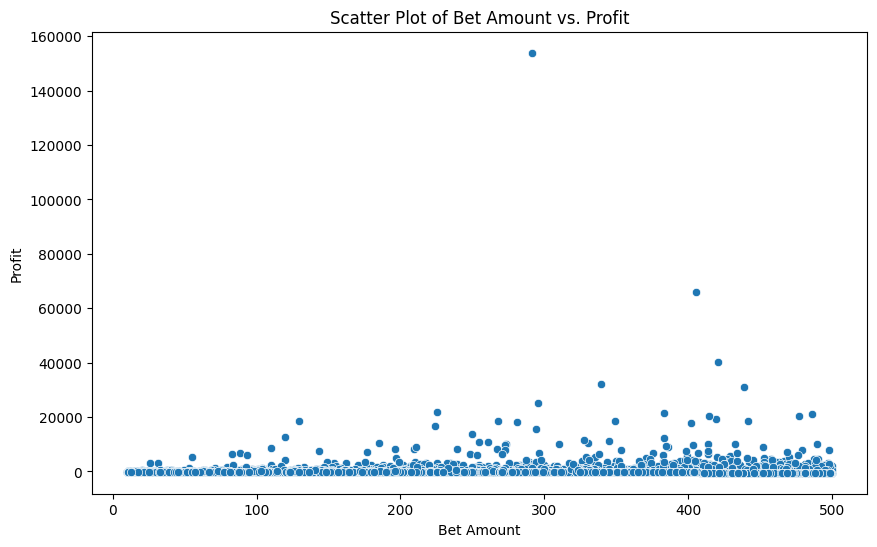

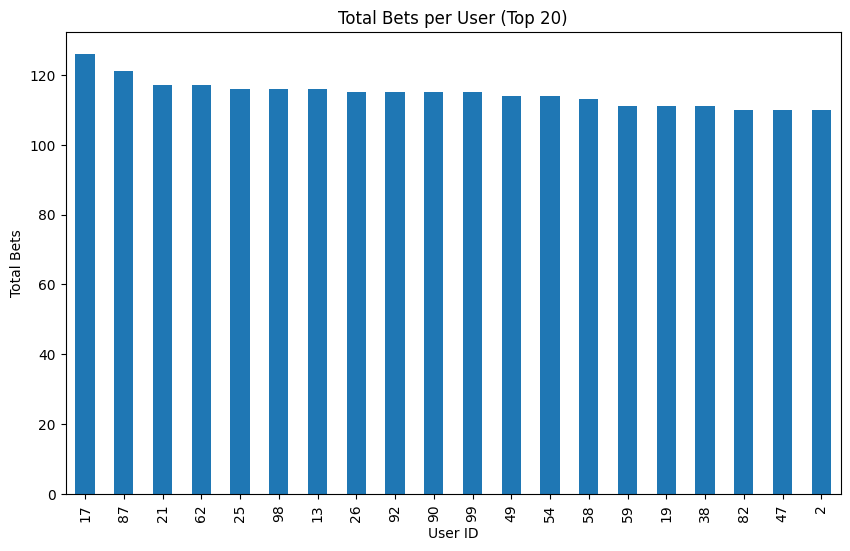

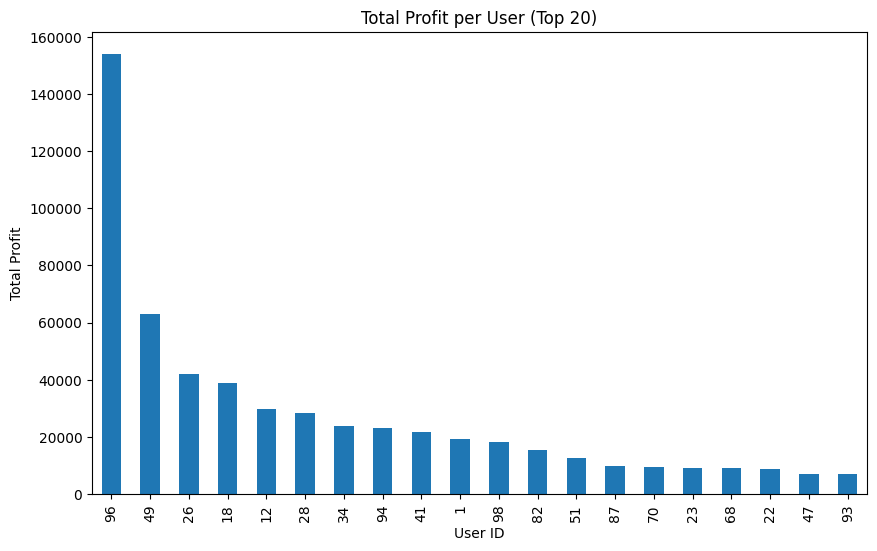

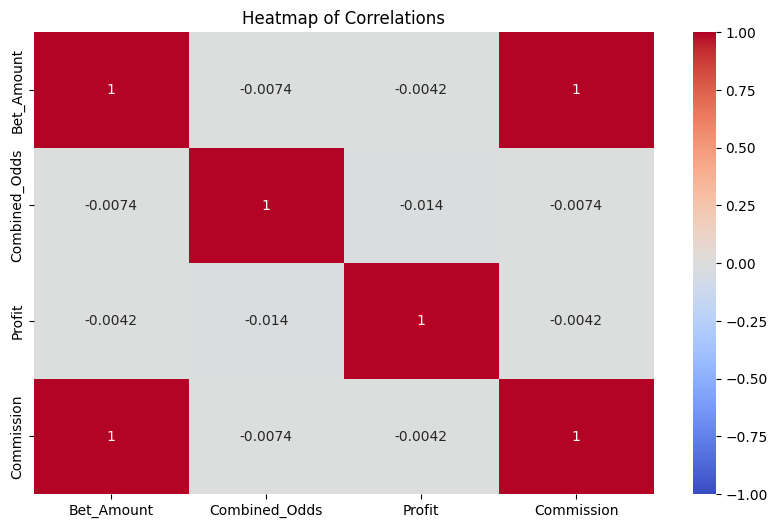

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Aggregate Data Analysis
# Total Bets and Total Amount Bet per User
user_aggregate = df_mock.groupby('User_ID').agg(
    Total_Bets=('User_ID', 'count'),
    Total_Amount_Bet=('Bet_Amount', 'sum'),
    Average_Bet_Amount=('Bet_Amount', 'mean'),
    Total_Profit=('Profit', 'sum'),
    Wins=('Overall_Result', lambda x: (x == 'Win').sum()),
    Losses=('Overall_Result', lambda x: (x == 'Loss').sum())
)

# Calculate Win/Loss Ratio
user_aggregate['Win_Loss_Ratio'] = user_aggregate['Wins'] / user_aggregate['Losses']

# Display the aggregate data
print(user_aggregate.head())

# Visualizations
# Histogram of Bet Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Bet_Amount'], bins=30, kde=True)
plt.title('Histogram of Bet Amounts')
plt.xlabel('Bet Amount')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot of Bet Amount vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bet_Amount', y='Profit', data=df_mock)
plt.title('Scatter Plot of Bet Amount vs. Profit')
plt.xlabel('Bet Amount')
plt.ylabel('Profit')
plt.show()

# Bar Plot of Total Bets per User
plt.figure(figsize=(10, 6))
user_aggregate['Total_Bets'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Total Bets per User (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Total Bets')
plt.show()

# Bar Plot of Total Profit per User
plt.figure(figsize=(10, 6))
user_aggregate['Total_Profit'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Total Profit per User (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Total Profit')
plt.show()

# Heatmap of Correlations
plt.figure(figsize=(10, 6))
correlation_matrix = df_mock[['Bet_Amount', 'Combined_Odds', 'Profit', 'Commission']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlations')
plt.show()

In [98]:
user_96_data = df_mock[df_mock['User_ID'] == 96]

In [99]:
user_96_data = df_mock[(df_mock['User_ID'] == 96) & (df_mock['Payout'] > 0)]

In [100]:
user_96_data.head(20)

,User_ID,Num_Bets,Bet_Amount,Odds,Implied_Probabilities,Combined_Probability,Combined_Odds,Vig,Overall_Result,Payout,Profit,Commission
747,96,2,280.37,"[-400, -200]","[0.8, 0.6666666666666666]",0.533333,1.875000,0.466667,Win,525.693750,273.360750,28.037
1381,96,6,291.57,"[-105, 110, 100, 115, 500, 400]","[0.5121951219512195, 0.47619047619047616, 0.5,...",0.001891,528.900000,1.320169,Win,154211.373000,153948.960000,29.157
1820,96,2,462.50,"[-400, 115]","[0.8, 0.46511627906976744]",0.372093,2.687500,0.265116,Win,1242.968750,826.718750,46.250
1836,96,2,96.51,"[115, 180]","[0.46511627906976744, 0.35714285714285715]",0.166113,6.020000,-0.177741,Win,580.990200,494.131200,9.651
4238,96,3,96.45,"[180, 110, -200]","[0.35714285714285715, 0.47619047619047616, 0.6...",0.113379,8.820000,0.500000,Win,850.689000,763.884000,9.645
4332,96,2,162.97,"[-105, 180]","[0.5121951219512195, 0.35714285714285715]",0.182927,5.466667,-0.130662,Win,890.902667,744.229667,16.297
5249,96,2,42.26,"[100, -400]","[0.5, 0.8]",0.400000,2.500000,0.300000,Win,105.650000,67.616000,4.226
5319,96,3,487.81,"[100, -150, 220]","[0.5, 0.6, 0.3125]",0.093750,10.666667,0.412500,Win,5203.306667,4764.277667,48.781
5536,96,3,54.10,"[-120, 110, -150]","[0.5454545454545454, 0.47619047619047616, 0.6]",0.155844,6.416667,0.621645,Win,347.141667,298.451667,5.410
6898,96,3,103.61,"[-400, -500, -450]","[0.8, 0.8333333333333334, 0.8181818181818182]",0.545455,1.833333,1.451515,Win,189.951667,96.702667,10.361


In [101]:
print(df_mock.head())

   User_ID  Num_Bets  Bet_Amount                                  Odds  \
0       52         6       81.33  [-120, -120, -150, -450, -150, -450]   
1       93         6      417.26      [105, 300, -120, 100, 110, -400]   
2       15         2      180.86                           [-200, 180]   
3       72         5      206.07        [-400, -200, -150, -500, -500]   
4       61         3      448.09                       [115, 500, 180]   

                               Implied_Probabilities  Combined_Probability  \
0  [0.5454545454545454, 0.5454545454545454, 0.6, ...              0.071700   
1  [0.4878048780487805, 0.25, 0.5454545454545454,...              0.012670   
2          [0.6666666666666666, 0.35714285714285715]              0.238095   
3  [0.8, 0.6666666666666666, 0.6, 0.8333333333333...              0.222222   
4  [0.46511627906976744, 0.16666666666666666, 0.3...              0.027685   

   Combined_Odds       Vig Overall_Result   Payout   Profit  Commission  
0      13.94

Correlation Matrix:
                Payout  Average_Odds
Payout        1.000000     -0.005147
Average_Odds -0.005147      1.000000


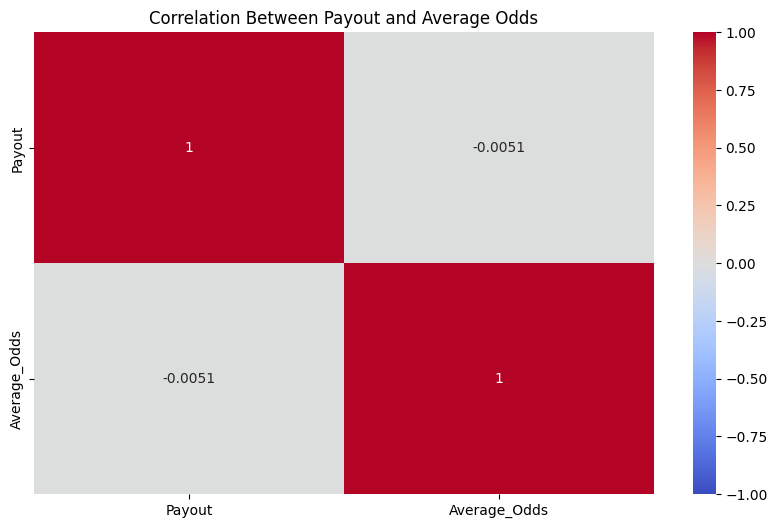

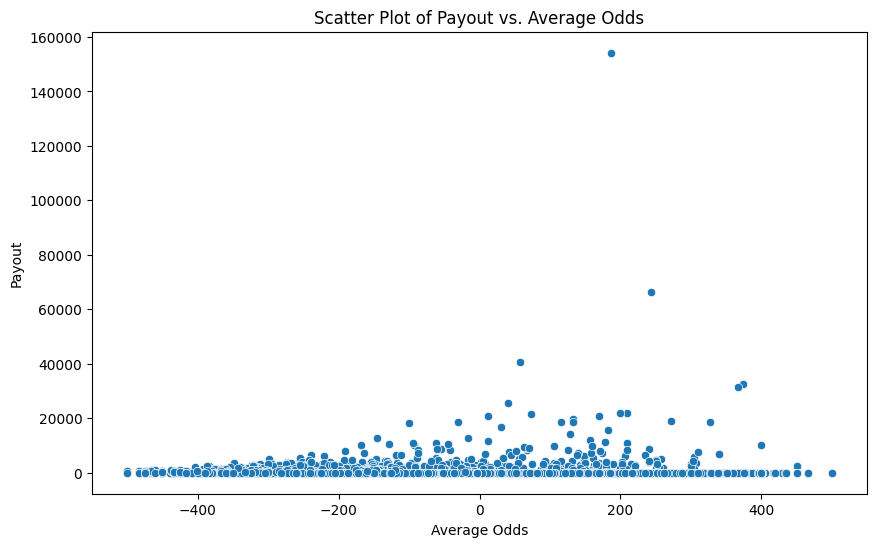

In [102]:
# Calculate Average Odds for Each Entry
df_mock['Average_Odds'] = df_mock['Odds'].apply(lambda x: np.mean(x))

# Perform Correlation Analysis Between Payout and Average Odds
correlation = df_mock[['Payout', 'Average_Odds']].corr()

# Display the Correlation Matrix
print("Correlation Matrix:")
print(correlation)

# Visualize the Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Payout and Average Odds')
plt.show()

# Scatter Plot of Payout vs. Average Odds
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Odds', y='Payout', data=df_mock)
plt.title('Scatter Plot of Payout vs. Average Odds')
plt.xlabel('Average Odds')
plt.ylabel('Payout')
plt.show()

C:\Users\Mitch\AppData\Local\Temp\ipykernel_39812\2615755013.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_mock.corr()


Correlation Matrix:
                       User_ID  Num_Bets  Bet_Amount  Combined_Probability  \
User_ID               1.000000  0.019268    0.011291             -0.014616   
Num_Bets              0.019268  1.000000   -0.002152             -0.590126   
Bet_Amount            0.011291 -0.002152    1.000000              0.024266   
Combined_Probability -0.014616 -0.590126    0.024266              1.000000   
Combined_Odds        -0.008192  0.265896   -0.007398             -0.193010   
Vig                   0.018260  0.786559    0.011969             -0.130832   
Payout                0.006119 -0.014192    0.056127              0.009047   
Profit                0.005446 -0.014084   -0.004238              0.007595   
Commission            0.011291 -0.002152    1.000000              0.024266   
Average_Odds         -0.001556  0.009885   -0.027428             -0.681607   

                      Combined_Odds       Vig    Payout    Profit  Commission  \
User_ID                   -0.008192  0.0

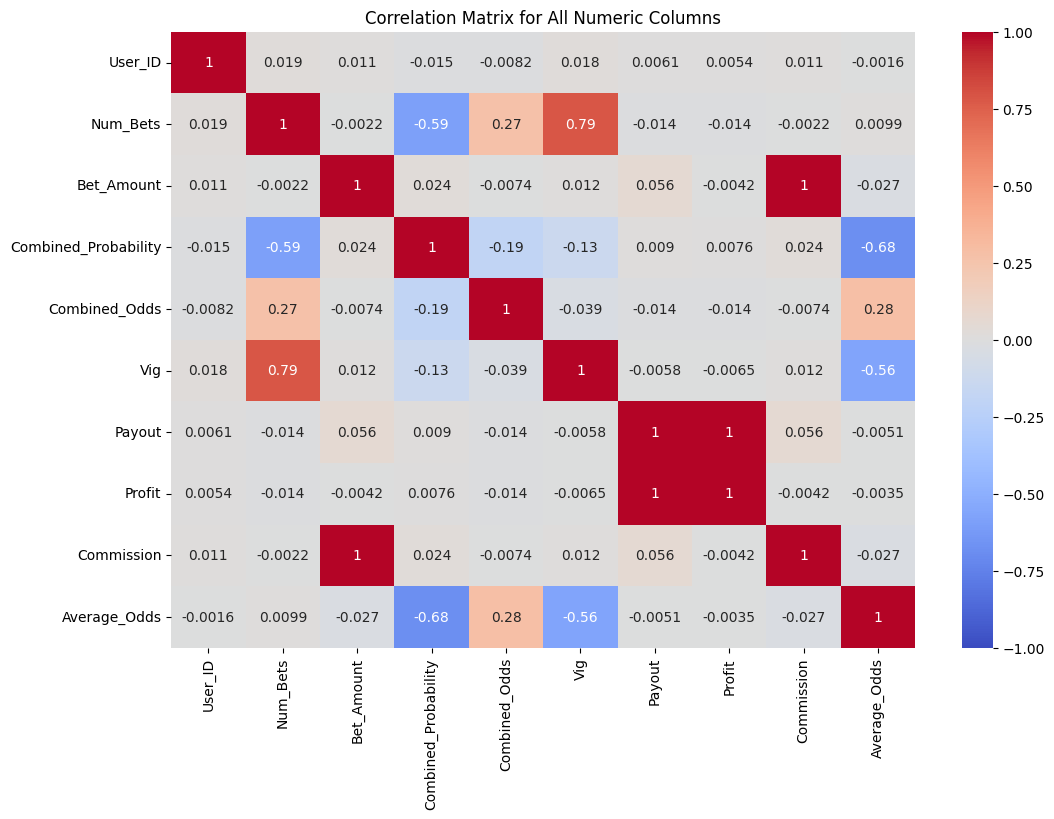

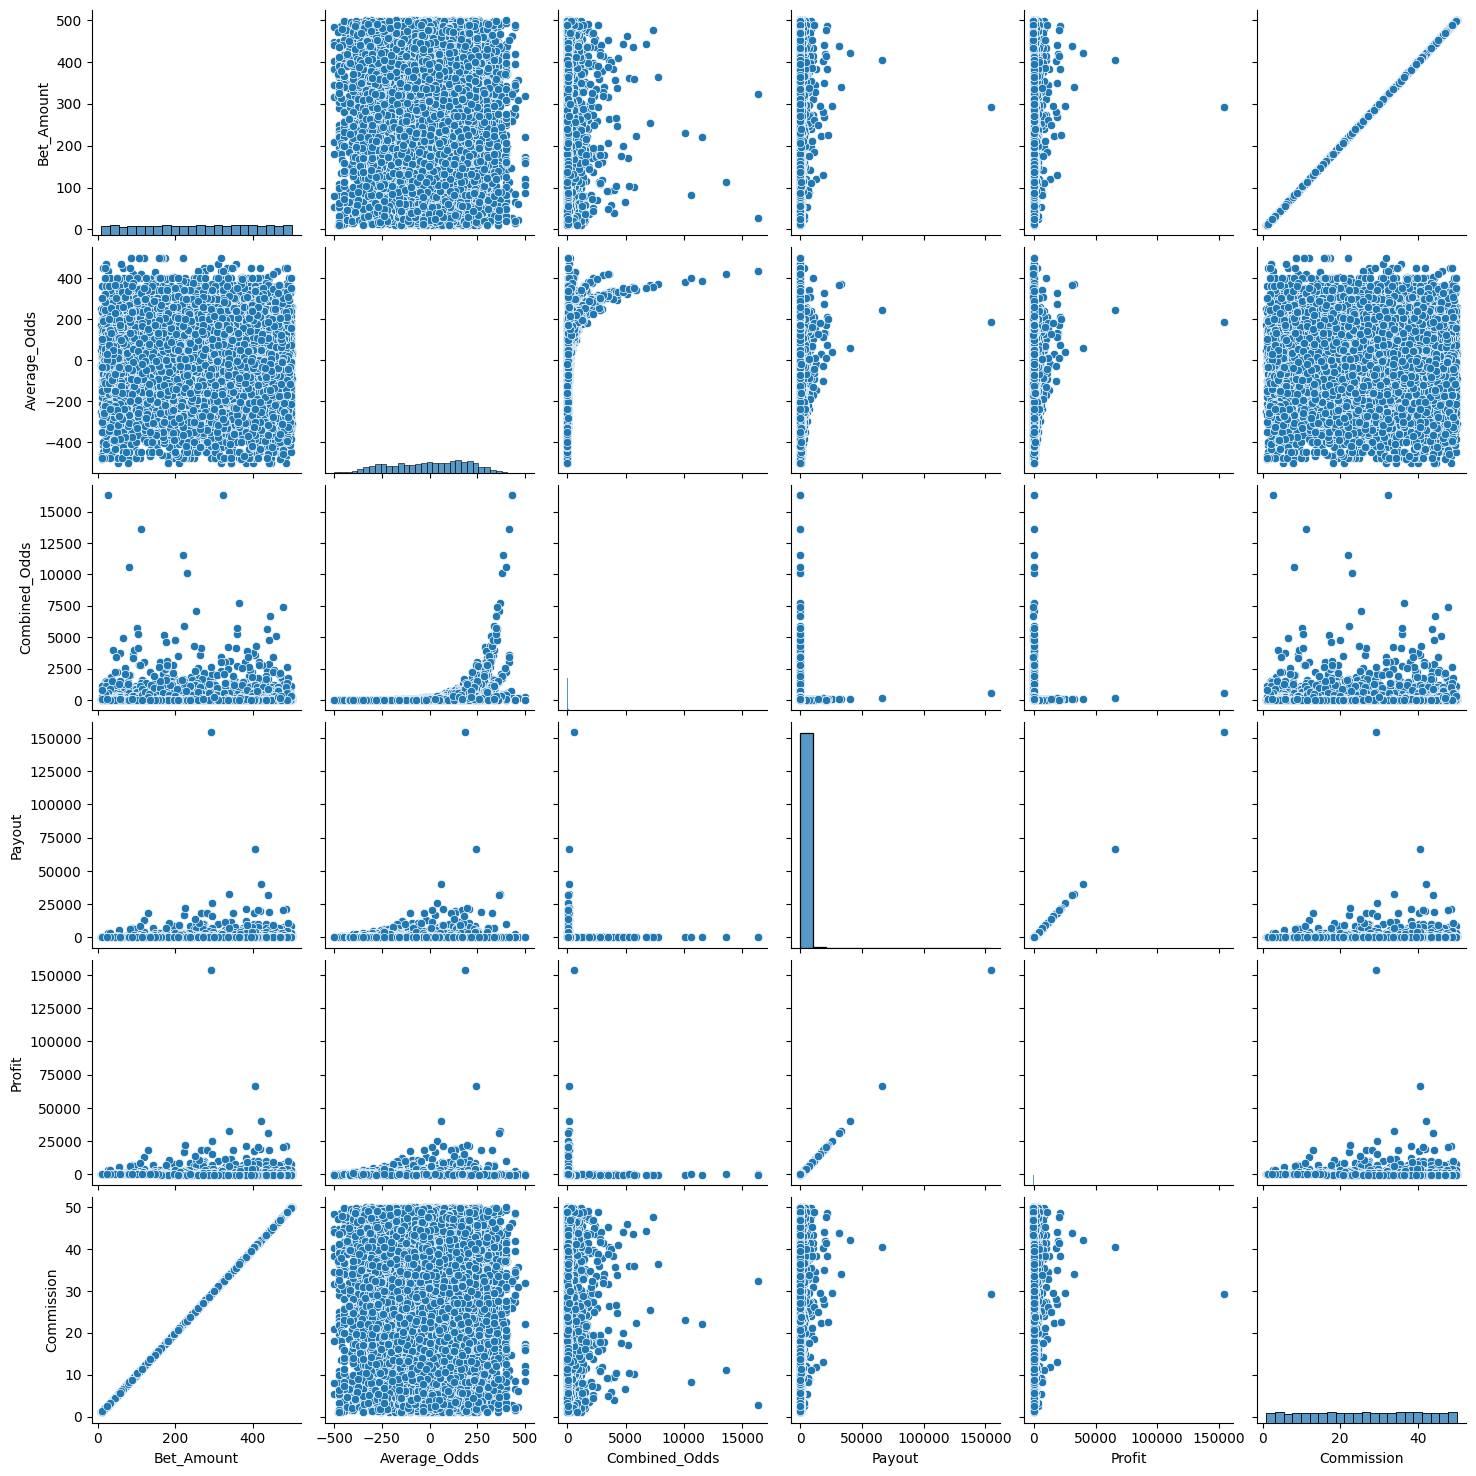

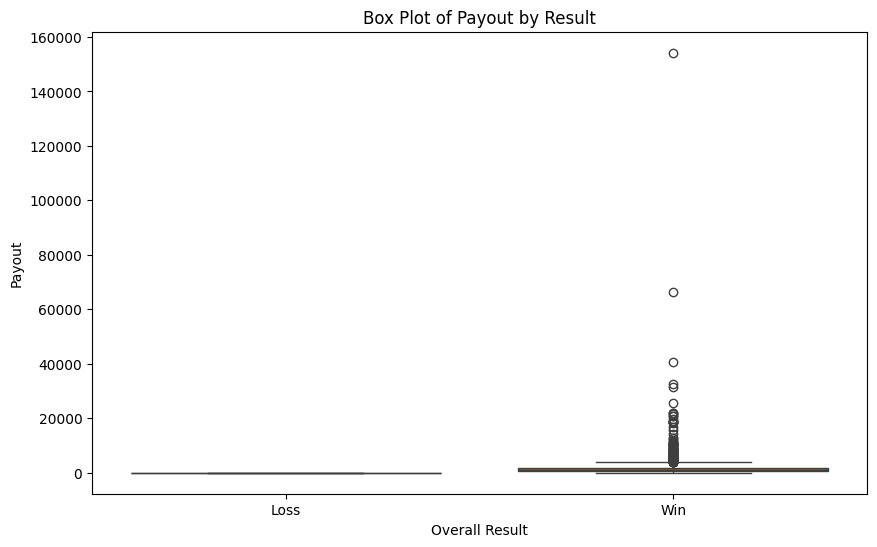

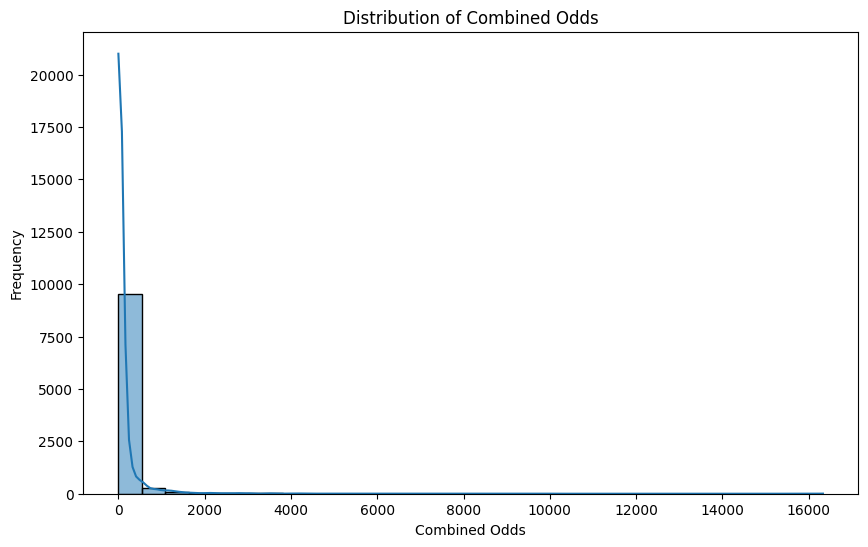

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Calculate Average Odds for Each Entry
df_mock['Average_Odds'] = df_mock['Odds'].apply(lambda x: np.mean(x))

# Correlation Matrix for All Numeric Columns
correlation_matrix = df_mock.corr()

# Display the Correlation Matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for All Numeric Columns')
plt.show()

# Pair Plot for Selected Columns
selected_columns = ['Bet_Amount', 'Average_Odds', 'Combined_Odds', 'Payout', 'Profit', 'Commission']
sns.pairplot(df_mock[selected_columns])
plt.show()

# Box Plot of Payout by Result
plt.figure(figsize=(10, 6))
sns.boxplot(x='Overall_Result', y='Payout', data=df_mock)
plt.title('Box Plot of Payout by Result')
plt.xlabel('Overall Result')
plt.ylabel('Payout')
plt.show()

# Distribution of Combined Odds
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Combined_Odds'], bins=30, kde=True)
plt.title('Distribution of Combined Odds')
plt.xlabel('Combined Odds')
plt.ylabel('Frequency')
plt.show()

C:\Users\Mitch\AppData\Local\Temp\ipykernel_39812\3798670068.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_mock.corr()


Correlation Matrix:
                       User_ID  Num_Bets  Bet_Amount  Combined_Probability  \
User_ID               1.000000  0.019268    0.011291             -0.014616   
Num_Bets              0.019268  1.000000   -0.002152             -0.590126   
Bet_Amount            0.011291 -0.002152    1.000000              0.024266   
Combined_Probability -0.014616 -0.590126    0.024266              1.000000   
Combined_Odds        -0.008192  0.265896   -0.007398             -0.193010   
Vig                   0.018260  0.786559    0.011969             -0.130832   
Payout                0.006119 -0.014192    0.056127              0.009047   
Profit                0.005446 -0.014084   -0.004238              0.007595   
Commission            0.011291 -0.002152    1.000000              0.024266   
Average_Odds         -0.001556  0.009885   -0.027428             -0.681607   

                      Combined_Odds       Vig    Payout    Profit  Commission  \
User_ID                   -0.008192  0.0

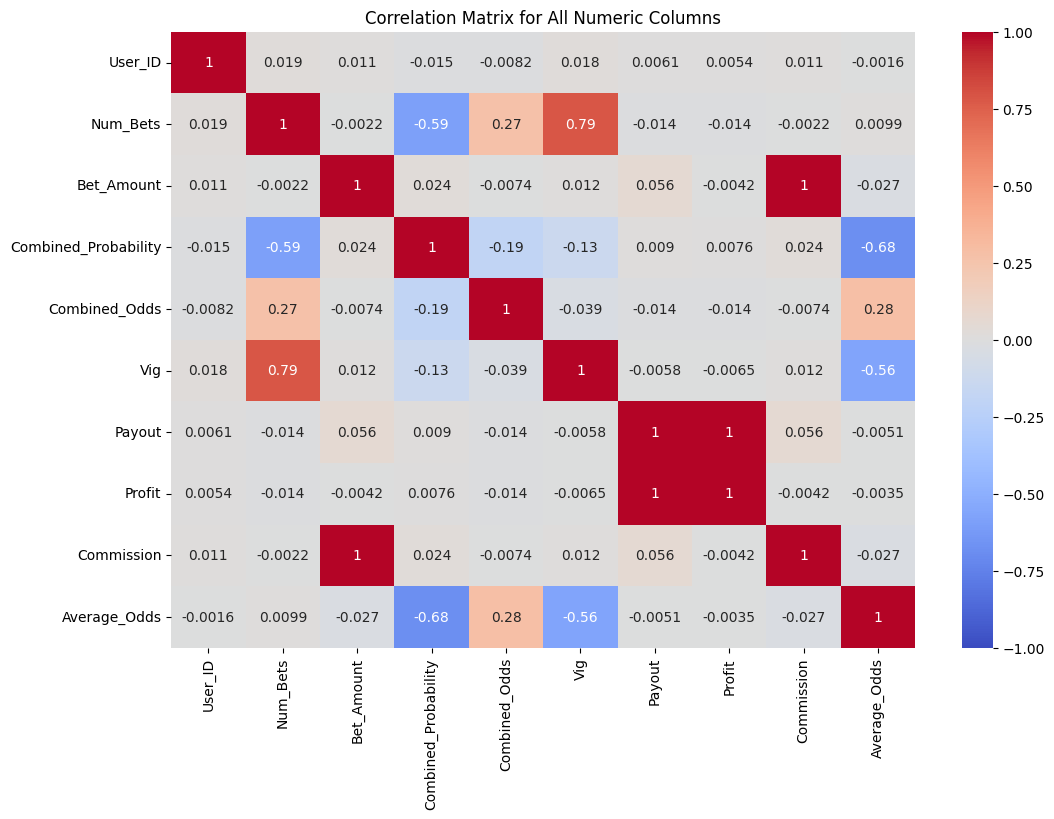

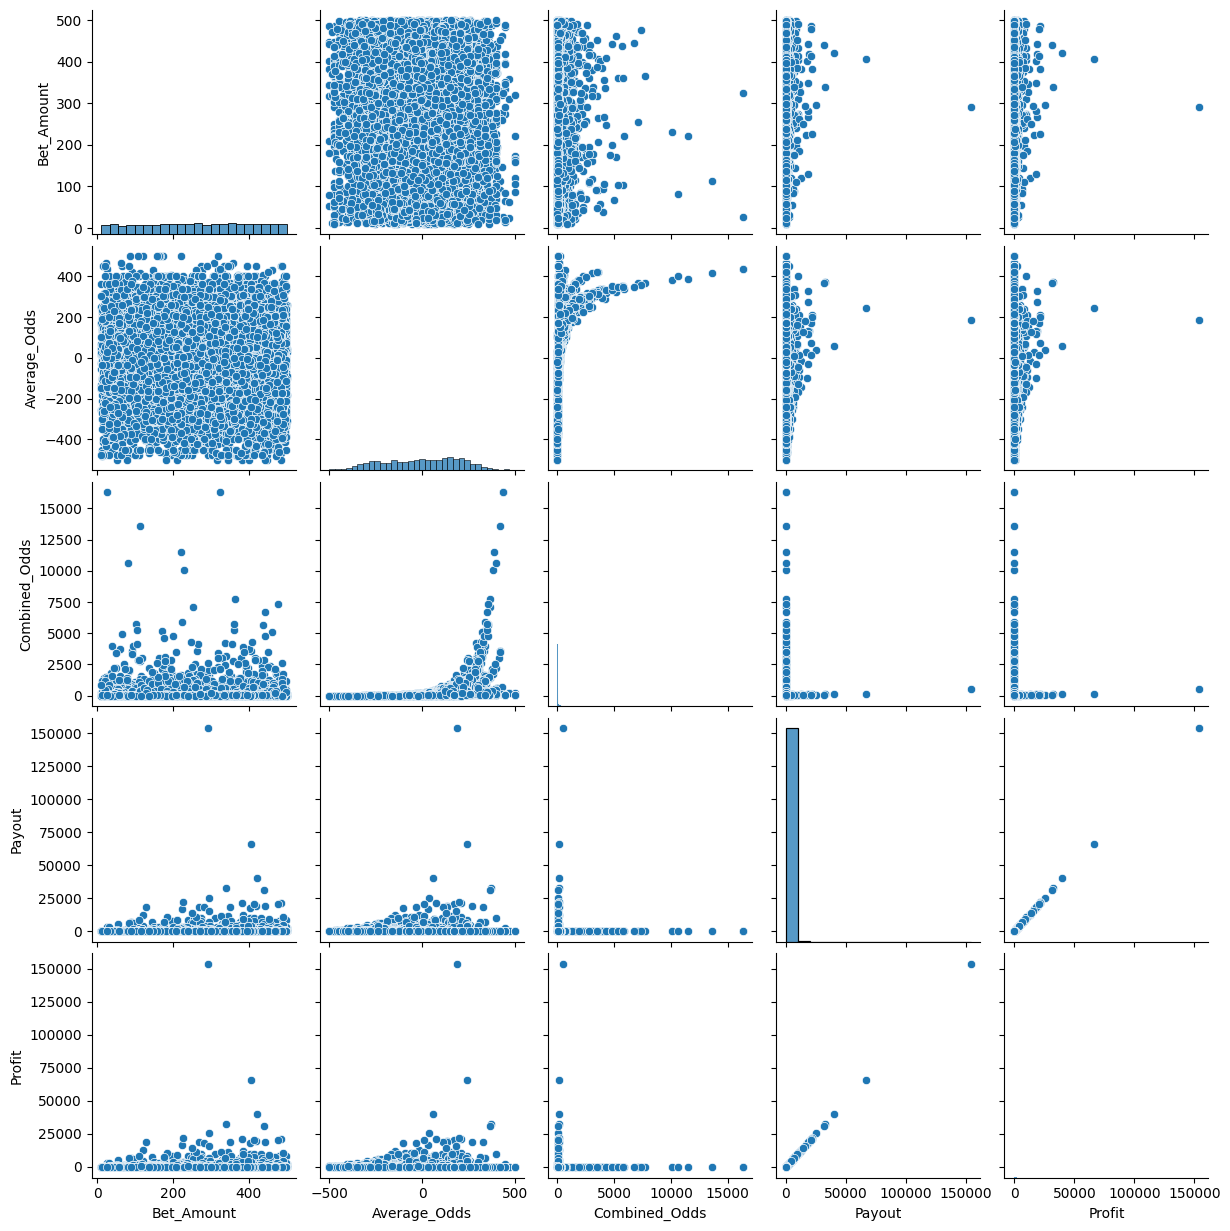

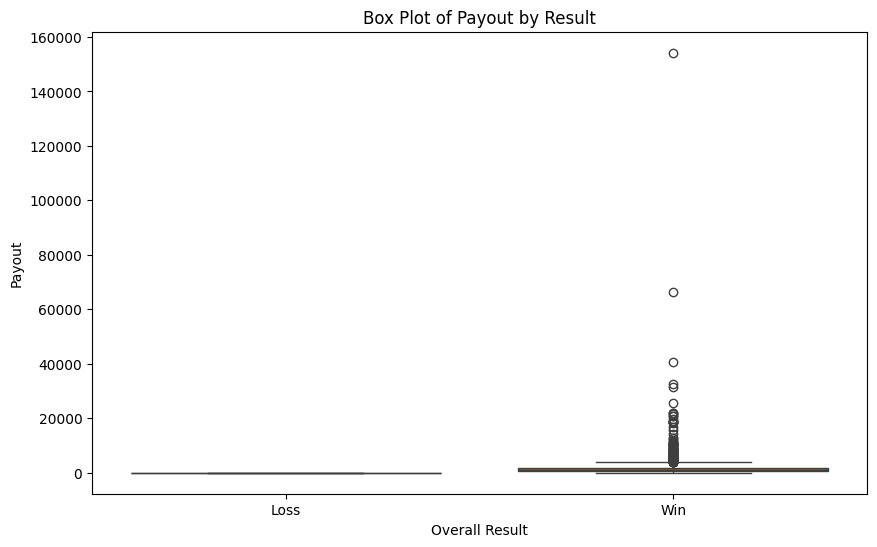

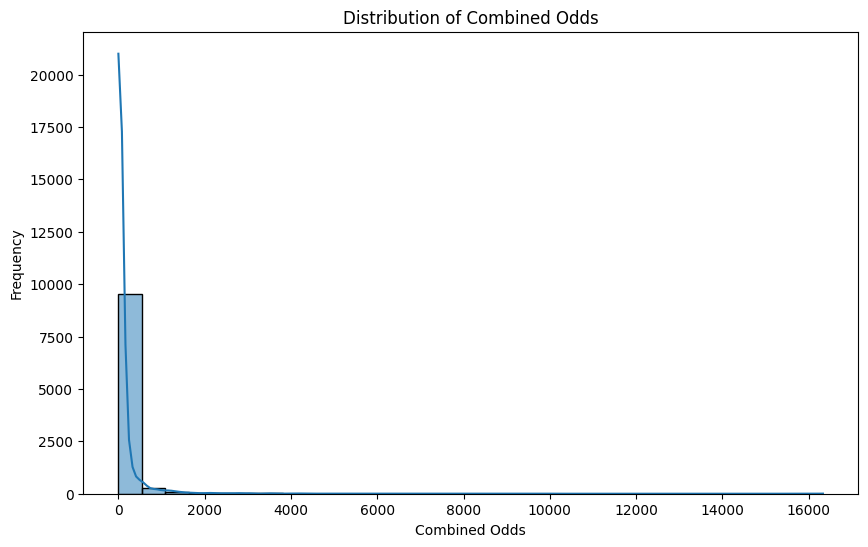

In [104]:
# Assuming df_mock is already created and contains the necessary data

# Calculate Average Odds for Each Entry
df_mock['Average_Odds'] = df_mock['Odds'].apply(lambda x: np.mean(x))

# Correlation Matrix for All Numeric Columns
correlation_matrix = df_mock.corr()

# Display the Correlation Matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for All Numeric Columns')
plt.show()

# Pair Plot for Selected Columns (excluding 'Commission')
selected_columns = ['Bet_Amount', 'Average_Odds', 'Combined_Odds', 'Payout', 'Profit']
sns.pairplot(df_mock[selected_columns])
plt.show()

# Box Plot of Payout by Result
plt.figure(figsize=(10, 6))
sns.boxplot(x='Overall_Result', y='Payout', data=df_mock)
plt.title('Box Plot of Payout by Result')
plt.xlabel('Overall Result')
plt.ylabel('Payout')
plt.show()

# Distribution of Combined Odds
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Combined_Odds'], bins=30, kde=True)
plt.title('Distribution of Combined Odds')
plt.xlabel('Combined Odds')
plt.ylabel('Frequency')
plt.show()

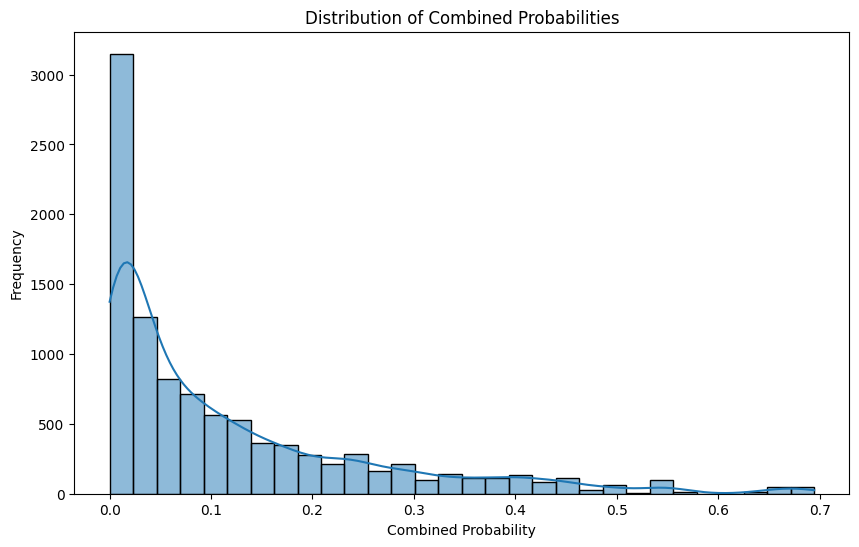

In [105]:
# Visualize the Distribution of Combined Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Combined_Probability'], bins=30, kde=True)
plt.title('Distribution of Combined Probabilities')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()


Combined Probability Bin Counts:
(0.0, 0.1]    6195
(0.1, 0.2]    1741
(0.2, 0.3]     957
(0.3, 0.4]     523
(0.4, 0.5]     366
(0.5, 0.6]     109
(0.6, 0.7]     109
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
Name: Probability_Bin, dtype: int64

Combined Odds Bin Counts:
(0.0, 1632.96]          9884
(1632.96, 3265.92]        74
(3265.92, 4898.88]        23
(4898.88, 6531.84]         9
(6531.84, 8164.8]          4
(8164.8, 9797.76]          0
(9797.76, 11430.72]        2
(11430.72, 13063.68]       1
(13063.68, 14696.64]       1
(14696.64, 16329.6]        2
Name: Odds_Bin, dtype: int64


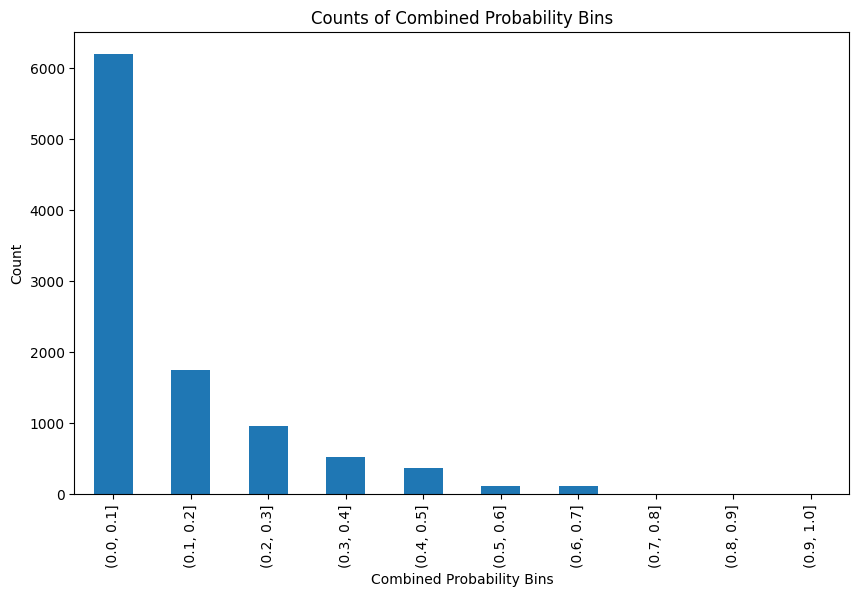

In [106]:
# Assuming df_mock is already created and contains the necessary data

# Define bins for Combined Probabilities and Combined Odds
probability_bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
odds_bins = np.linspace(0, df_mock['Combined_Odds'].max(), 11)  # 10 bins from 0 to max Combined Odds

# Bin the Combined Probabilities and Combined Odds
df_mock['Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=probability_bins)
df_mock['Odds_Bin'] = pd.cut(df_mock['Combined_Odds'], bins=odds_bins)

# Count the occurrences in each bin
probability_bin_counts = df_mock['Probability_Bin'].value_counts().sort_index()
odds_bin_counts = df_mock['Odds_Bin'].value_counts().sort_index()

# Display the bin counts
print("Combined Probability Bin Counts:")
print(probability_bin_counts)
print("\nCombined Odds Bin Counts:")
print(odds_bin_counts)

# Visualize the Binned Data
# Bar Plot for Combined Probability Bins
plt.figure(figsize=(10, 6))
probability_bin_counts.plot(kind='bar')
plt.title('Counts of Combined Probability Bins')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Count')
plt.show()


Bets with Combined Probability > 0.5:
      User_ID  Num_Bets  Bet_Amount  Combined_Probability  Combined_Odds  \
130        33         2      270.85              0.533333       1.875000   
184        84         2      173.05              0.545455       1.833333   
192         1         2      305.29              0.681818       1.466667   
245        24         2      383.02              0.694444       1.440000   
339        76         2      478.55              0.545455       1.833333   
...       ...       ...         ...                   ...            ...   
9740        7         3      228.48              0.523636       1.909722   
9819       27         2      171.73              0.533333       1.875000   
9873       93         2      181.40              0.694444       1.440000   
9929       55         2      196.17              0.533333       1.875000   
9930       62         2       31.97              0.545455       1.833333   

         Payout     Profit  
130   507.84375  264

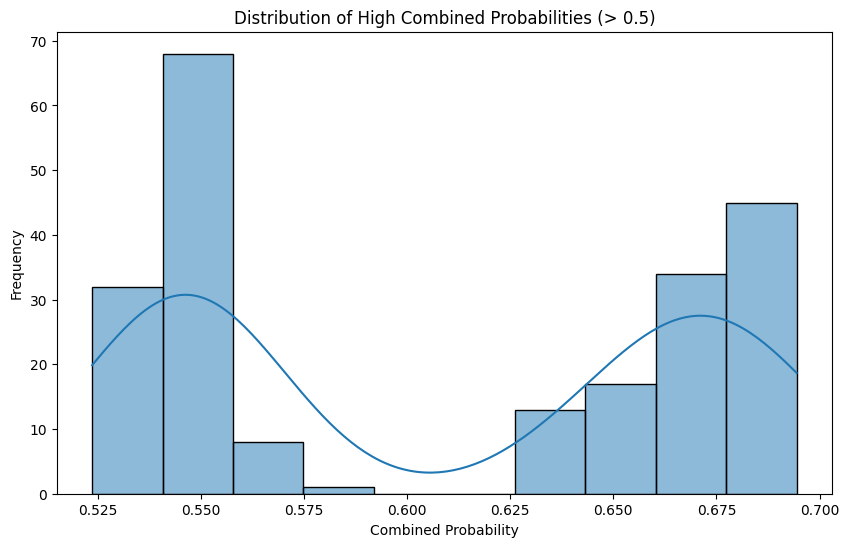

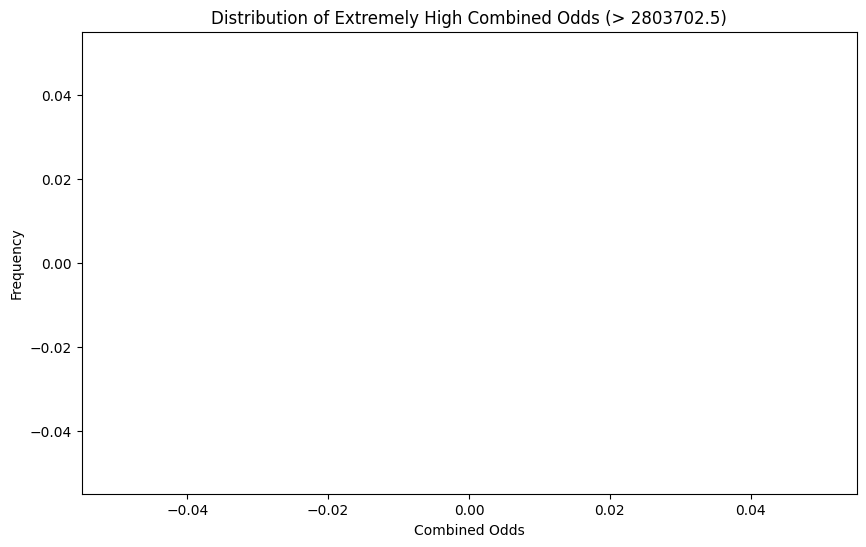

In [107]:
high_prob_bets = df_mock[df_mock['Combined_Probability'] > 0.5]

# Display High Probability Bets
print("Bets with Combined Probability > 0.5:")
print(high_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Analyze Bets with Extremely High Combined Odds (e.g., > 2803702.5)
high_odds_bets = df_mock[df_mock['Combined_Odds'] > 2803702.5]

# Display High Odds Bets
print("Bets with Extremely High Combined Odds:")
print(high_odds_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Visualize High Probability Bets
plt.figure(figsize=(10, 6))
sns.histplot(high_prob_bets['Combined_Probability'], bins=10, kde=True)
plt.title('Distribution of High Combined Probabilities (> 0.5)')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()

# Visualize High Odds Bets
plt.figure(figsize=(10, 6))
sns.histplot(high_odds_bets['Combined_Odds'], bins=10, kde=True)
plt.title('Distribution of Extremely High Combined Odds (> 2803702.5)')
plt.xlabel('Combined Odds')
plt.ylabel('Frequency')
plt.show()

Finer Combined Probability Bin Counts:
(0.0, 0.01]     1947
(0.01, 0.02]     992
(0.02, 0.03]     678
(0.03, 0.04]     513
(0.04, 0.05]     455
(0.05, 0.06]     386
(0.06, 0.07]     280
(0.07, 0.08]     351
(0.08, 0.09]     292
(0.09, 0.1]      301
(0.1, 0.11]      188
(0.11, 0.12]     254
(0.12, 0.13]     235
(0.13, 0.14]     190
(0.14, 0.15]     175
(0.15, 0.16]     125
(0.16, 0.17]     165
(0.17, 0.18]     172
(0.18, 0.19]     103
(0.19, 0.2]      134
Name: Finer_Probability_Bin, dtype: int64


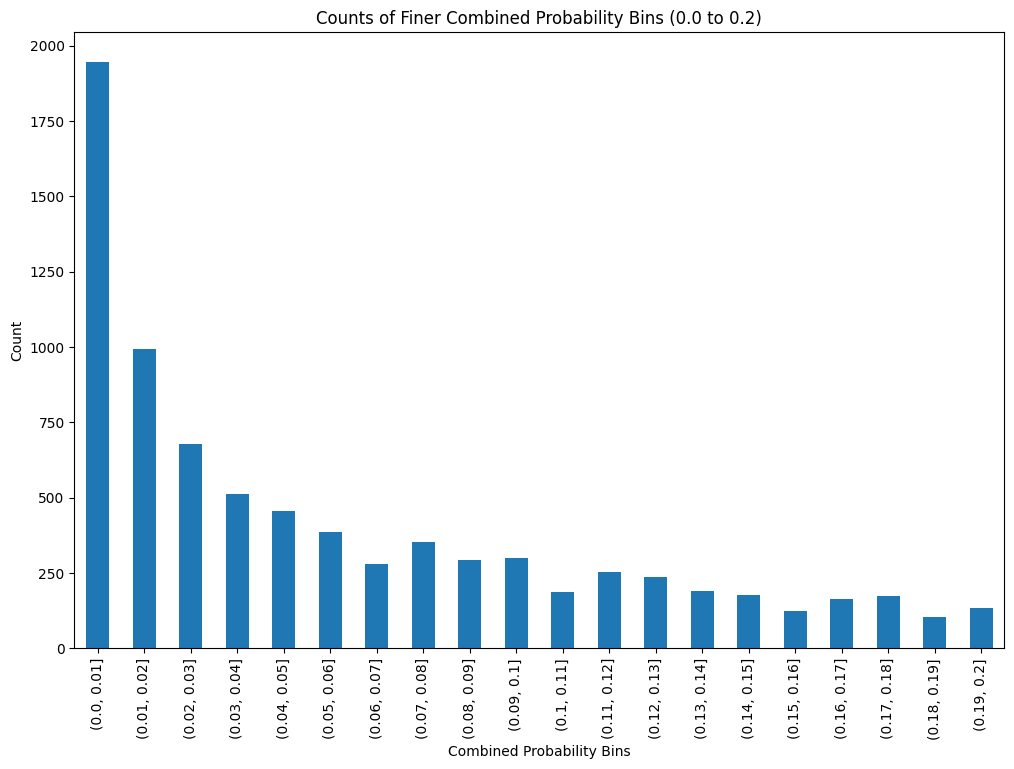

In [108]:
# Define finer bins for Combined Probabilities from 0.0 to 0.2 with a step of 0.01
finer_probability_bins = np.arange(0, 0.21, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Count the occurrences in each bin
finer_probability_bin_counts = df_mock['Finer_Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Finer Combined Probability Bin Counts:")
print(finer_probability_bin_counts)

# Visualize the Binned Data
# Bar Plot for Finer Combined Probability Bins
plt.figure(figsize=(12, 8))
finer_probability_bin_counts.plot(kind='bar')
plt.title('Counts of Finer Combined Probability Bins (0.0 to 0.2)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Count')
plt.show()

Finer Combined Probability Bin Counts:
(0.0, 0.01]     1947
(0.01, 0.02]     992
(0.02, 0.03]     678
(0.03, 0.04]     513
(0.04, 0.05]     455
(0.05, 0.06]     386
(0.06, 0.07]     280
(0.07, 0.08]     351
(0.08, 0.09]     292
(0.09, 0.1]      301
(0.1, 0.11]      188
(0.11, 0.12]     254
(0.12, 0.13]     235
(0.13, 0.14]     190
(0.14, 0.15]     175
(0.15, 0.16]     125
(0.16, 0.17]     165
(0.17, 0.18]     172
(0.18, 0.19]     103
(0.19, 0.2]      134
Name: Finer_Probability_Bin, dtype: int64
Bets with Combined Probability between 0-3%:
      User_ID  Num_Bets  Bet_Amount  Combined_Probability  Combined_Odds  \
1          93         6      417.26              0.012670      78.925000   
4          61         3      448.09              0.027685      36.120000   
6          83         5      276.68              0.005531     180.810000   
7          87         5      478.68              0.026608      37.583333   
10         88         3      241.88              0.019531      51.200000  

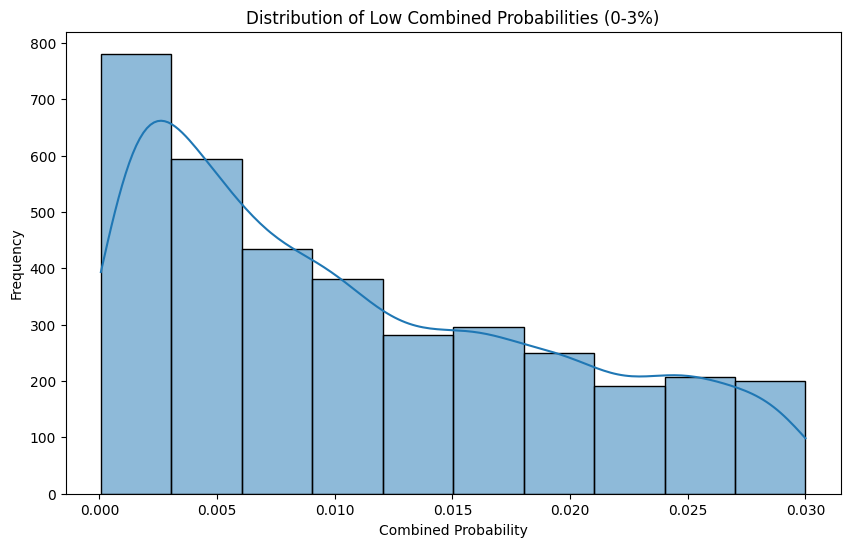

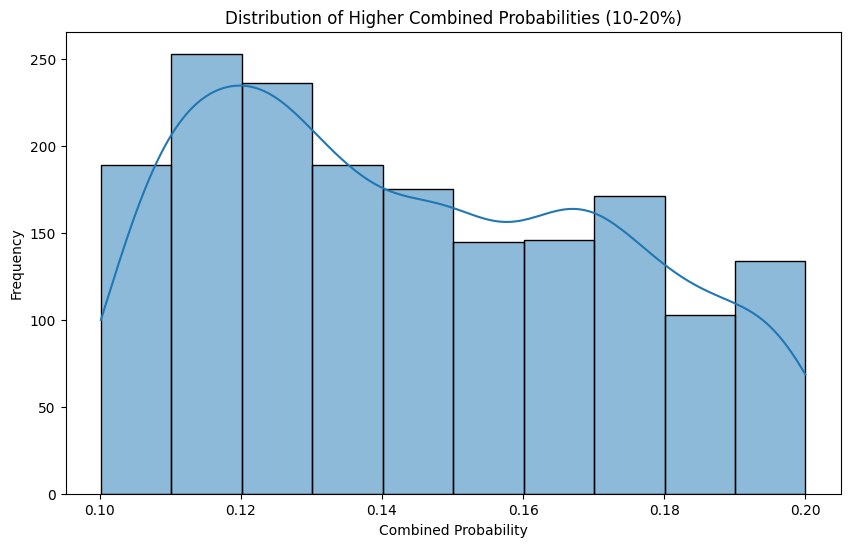

In [109]:
# Define finer bins for Combined Probabilities from 0.0 to 0.2 with a step of 0.01
finer_probability_bins = np.arange(0, 0.21, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Count the occurrences in each bin
finer_probability_bin_counts = df_mock['Finer_Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Finer Combined Probability Bin Counts:")
print(finer_probability_bin_counts)

# Analyze Bets in the 0-3% Probability Range
low_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.0) & (df_mock['Combined_Probability'] <= 0.03)]

# Display Low Probability Bets
print("Bets with Combined Probability between 0-3%:")
print(low_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Compare with Higher Probability Bins (e.g., 0.1-0.2)
higher_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.1) & (df_mock['Combined_Probability'] <= 0.2)]

# Display Higher Probability Bets
print("Bets with Combined Probability between 10-20%:")
print(higher_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit']])

# Visualize Low Probability Bets
plt.figure(figsize=(10, 6))
sns.histplot(low_prob_bets['Combined_Probability'], bins=10, kde=True)
plt.title('Distribution of Low Combined Probabilities (0-3%)')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()

# Visualize Higher Probability Bets
plt.figure(figsize=(10, 6))
sns.histplot(higher_prob_bets['Combined_Probability'], bins=10, kde=True)
plt.title('Distribution of Higher Combined Probabilities (10-20%)')
plt.xlabel('Combined Probability')
plt.ylabel('Frequency')
plt.show()

Finer Combined Probability Bin Counts:
(0.0, 0.01]     1947
(0.01, 0.02]     992
(0.02, 0.03]     678
(0.03, 0.04]     513
(0.04, 0.05]     455
(0.05, 0.06]     386
(0.06, 0.07]     280
(0.07, 0.08]     351
(0.08, 0.09]     292
(0.09, 0.1]      301
(0.1, 0.11]      188
(0.11, 0.12]     254
(0.12, 0.13]     235
(0.13, 0.14]     190
(0.14, 0.15]     175
(0.15, 0.16]     125
(0.16, 0.17]     165
(0.17, 0.18]     172
(0.18, 0.19]     103
(0.19, 0.2]      134
Name: Finer_Probability_Bin, dtype: int64
Bets with Combined Probability between 0-3%:
      User_ID  Num_Bets  Bet_Amount  Combined_Probability  Combined_Odds  \
1          93         6      417.26              0.012670      78.925000   
4          61         3      448.09              0.027685      36.120000   
6          83         5      276.68              0.005531     180.810000   
7          87         5      478.68              0.026608      37.583333   
10         88         3      241.88              0.019531      51.200000  

C:\Users\Mitch\AppData\Local\Temp\ipykernel_39812\4109569174.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)
C:\Users\Mitch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mitch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packag

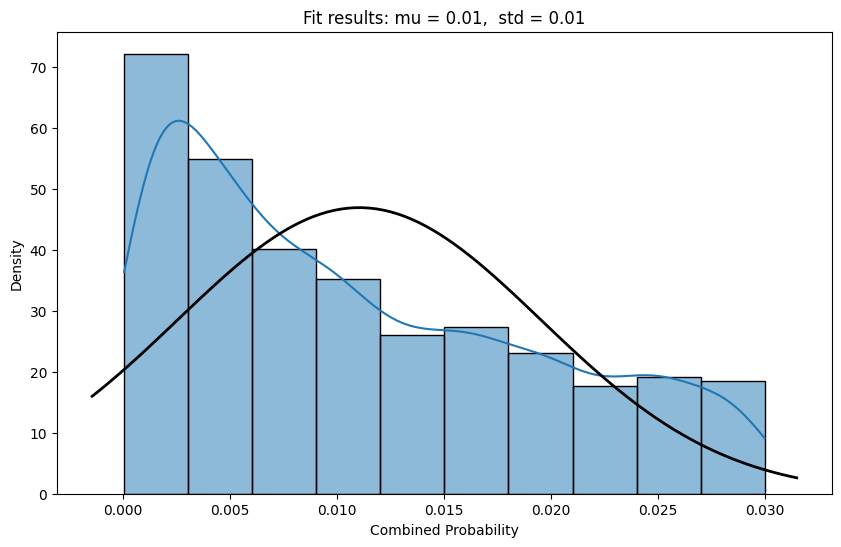

Success Rate by Combined Probability Bin:
Finer_Probability_Bin
(0.0, 0.01]     0.003595
(0.01, 0.02]    0.019153
(0.02, 0.03]    0.026549
(0.03, 0.04]         NaN
(0.04, 0.05]         NaN
(0.05, 0.06]         NaN
(0.06, 0.07]         NaN
(0.07, 0.08]         NaN
(0.08, 0.09]         NaN
(0.09, 0.1]          NaN
(0.1, 0.11]          NaN
(0.11, 0.12]         NaN
(0.12, 0.13]         NaN
(0.13, 0.14]         NaN
(0.14, 0.15]         NaN
(0.15, 0.16]         NaN
(0.16, 0.17]         NaN
(0.17, 0.18]         NaN
(0.18, 0.19]         NaN
(0.19, 0.2]          NaN
Name: Win, dtype: float64


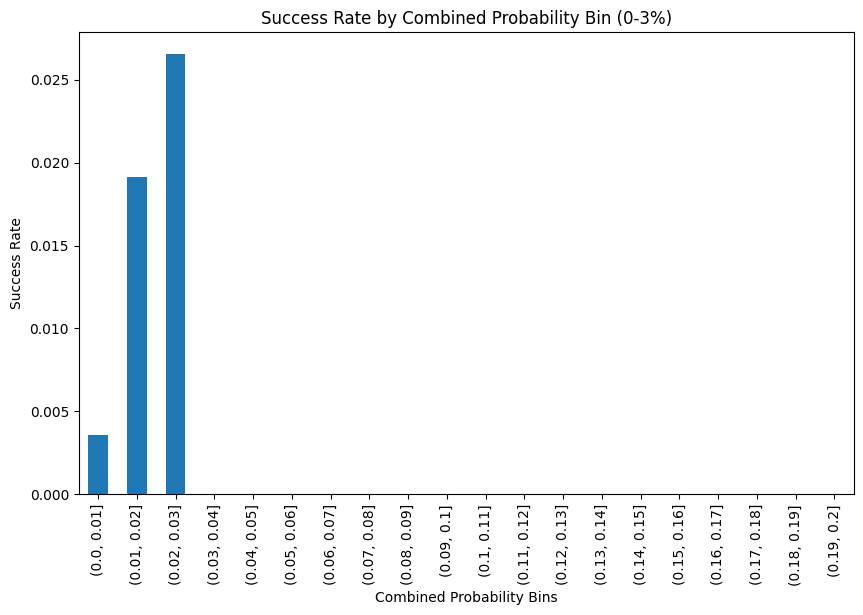

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming df_mock is already created and contains the necessary data

# Define finer bins for Combined Probabilities from 0.0 to 0.2 with a step of 0.01
finer_probability_bins = np.arange(0, 0.21, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Count the occurrences in each bin
finer_probability_bin_counts = df_mock['Finer_Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Finer Combined Probability Bin Counts:")
print(finer_probability_bin_counts)

# Analyze Bets in the 0-3% Probability Range
low_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.0) & (df_mock['Combined_Probability'] <= 0.03)]

# Display Low Probability Bets
print("Bets with Combined Probability between 0-3%:")
print(low_prob_bets[['User_ID', 'Num_Bets', 'Bet_Amount', 'Combined_Probability', 'Combined_Odds', 'Payout', 'Profit', 'Overall_Result']])

# Correlation Analysis
correlation = low_prob_bets[['Combined_Probability', 'Payout']].corr()
print("Correlation between Combined Probability and Payout:")
print(correlation)

# Logistic Regression to Model Probability of Winning
low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)
X = low_prob_bets[['Combined_Probability']]
y = low_prob_bets['Win']
log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred = log_reg.predict(X)
print("Logistic Regression Classification Report:")
print(classification_report(y, y_pred))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Bell Curve (Normal Distribution) Comparison
plt.figure(figsize=(10, 6))
sns.histplot(low_prob_bets['Combined_Probability'], bins=10, kde=True, stat="density")
mu, std = norm.fit(low_prob_bets['Combined_Probability'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Combined Probability')
plt.ylabel('Density')
plt.show()

# Success Rate Analysis
success_rate = low_prob_bets.groupby('Finer_Probability_Bin')['Win'].mean()
print("Success Rate by Combined Probability Bin:")
print(success_rate)

# Visualize Success Rate
plt.figure(figsize=(10, 6))
success_rate.plot(kind='bar')
plt.title('Success Rate by Combined Probability Bin (0-3%)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Success Rate')
plt.show()

Success Rate by Combined Probability Bin (0-3%):
Finer_Probability_Bin
(0.0, 0.01]     0.359527
(0.01, 0.02]    1.915323
(0.02, 0.03]    2.654867
Name: Win, dtype: float64


C:\Users\Mitch\AppData\Local\Temp\ipykernel_39812\3978422381.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)


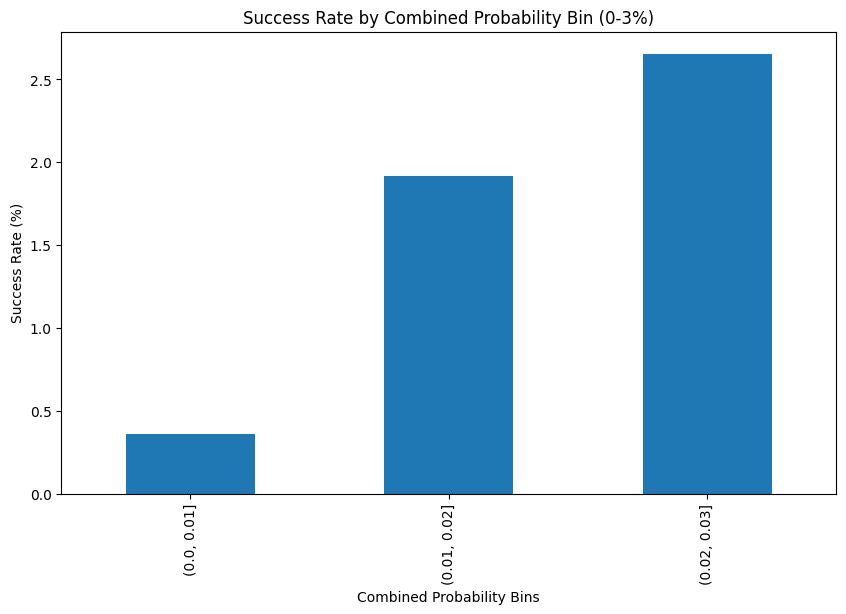

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Define finer bins for Combined Probabilities from 0.0 to 0.03 with a step of 0.01
finer_probability_bins = np.arange(0, 0.031, 0.01)

# Bin the Combined Probabilities
df_mock['Finer_Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=finer_probability_bins)

# Analyze Bets in the 0-3% Probability Range
low_prob_bets = df_mock[(df_mock['Combined_Probability'] > 0.0) & (df_mock['Combined_Probability'] <= 0.03)]

# Add a 'Win' column for success rate calculation
low_prob_bets['Win'] = low_prob_bets['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)

# Success Rate Analysis
success_rate = low_prob_bets.groupby('Finer_Probability_Bin')['Win'].mean() * 100  # Convert to percentage

# Display Success Rate
print("Success Rate by Combined Probability Bin (0-3%):")
print(success_rate)

# Visualize Success Rate
plt.figure(figsize=(10, 6))
success_rate.plot(kind='bar')
plt.title('Success Rate by Combined Probability Bin (0-3%)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Success Rate (%)')
plt.show()

Combined Probability Bin Counts:
(0.0, 0.1]    6195
(0.1, 0.2]    1741
(0.2, 0.3]     957
(0.3, 0.4]     523
(0.4, 0.5]     366
(0.5, 0.6]     109
(0.6, 0.7]     109
(0.7, 0.8]       0
(0.8, 0.9]       0
(0.9, 1.0]       0
Name: Probability_Bin, dtype: int64


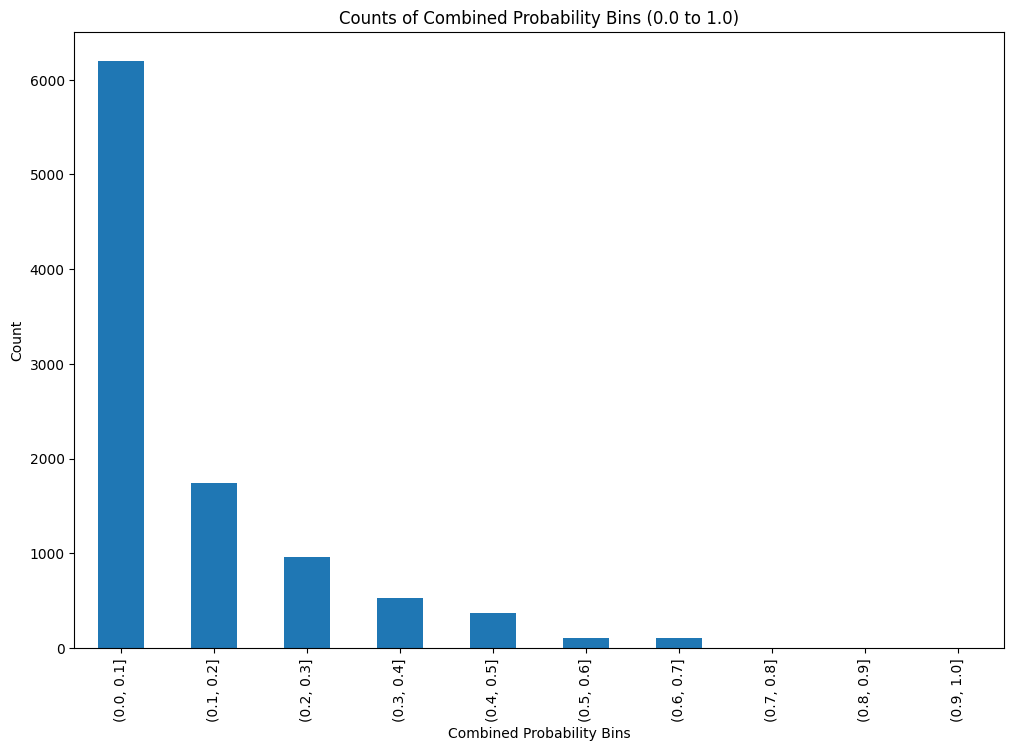

Success Rate by Combined Probability Bin (0.0 to 1.0):
Probability_Bin
(0.0, 0.1]     2.905569
(0.1, 0.2]    14.991384
(0.2, 0.3]    24.137931
(0.3, 0.4]    35.564054
(0.4, 0.5]    43.715847
(0.5, 0.6]    50.458716
(0.6, 0.7]    74.311927
(0.7, 0.8]          NaN
(0.8, 0.9]          NaN
(0.9, 1.0]          NaN
Name: Win, dtype: float64


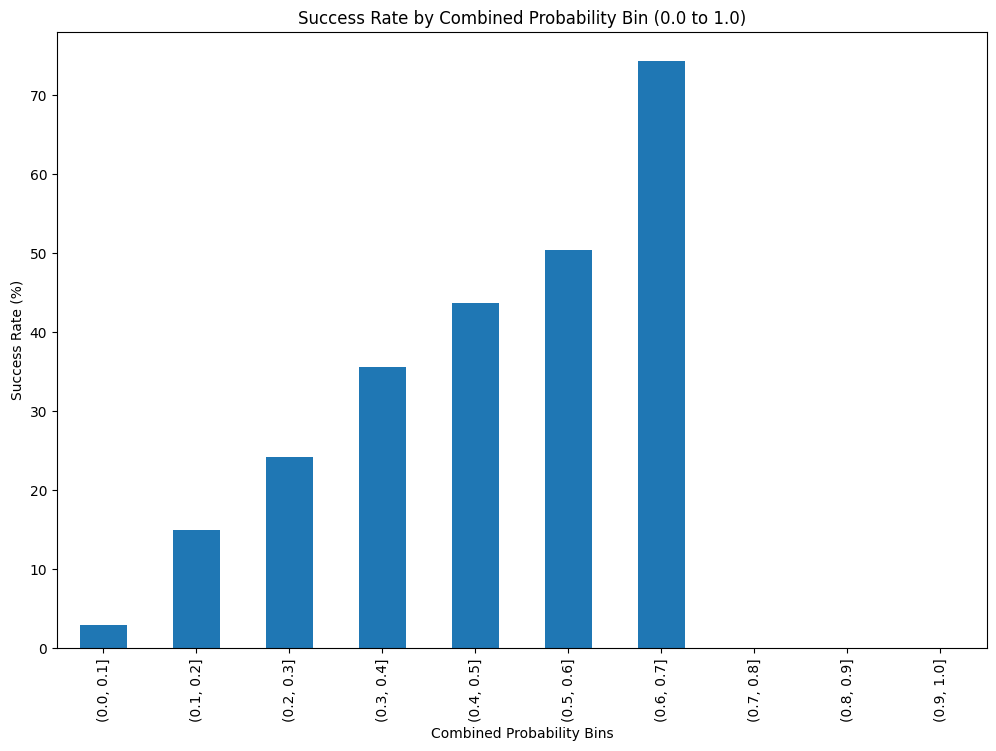

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_mock is already created and contains the necessary data

# Define finer bins for Combined Probabilities from 0.0 to 1.0 with a step of 0.1
probability_bins = np.arange(0, 1.1, 0.1)

# Bin the Combined Probabilities
df_mock['Probability_Bin'] = pd.cut(df_mock['Combined_Probability'], bins=probability_bins)

# Count the occurrences in each bin
probability_bin_counts = df_mock['Probability_Bin'].value_counts().sort_index()

# Display the bin counts
print("Combined Probability Bin Counts:")
print(probability_bin_counts)

# Visualize the Binned Data
# Bar Plot for Combined Probability Bins
plt.figure(figsize=(12, 8))
probability_bin_counts.plot(kind='bar')
plt.title('Counts of Combined Probability Bins (0.0 to 1.0)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Count')
plt.show()

# Success Rate Analysis for All Bins
df_mock['Win'] = df_mock['Overall_Result'].apply(lambda x: 1 if x == 'Win' else 0)
success_rate_all_bins = df_mock.groupby('Probability_Bin')['Win'].mean() * 100  # Convert to percentage

# Display Success Rate
print("Success Rate by Combined Probability Bin (0.0 to 1.0):")
print(success_rate_all_bins)

# Visualize Success Rate for All Bins
plt.figure(figsize=(12, 8))
success_rate_all_bins.plot(kind='bar')
plt.title('Success Rate by Combined Probability Bin (0.0 to 1.0)')
plt.xlabel('Combined Probability Bins')
plt.ylabel('Success Rate (%)')
plt.show()

In [113]:
import numpy as np

# Function to convert American odds to implied probability
def american_to_implied_probability(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Given odds
odds = [500, 115, 110, -400, -400, -150]

# Convert to implied probabilities
implied_probabilities = [american_to_implied_probability(odd) for odd in odds]
print("Implied Probabilities:", implied_probabilities)

# Calculate combined implied probability
combined_probability = np.prod(implied_probabilities)
print("Combined Implied Probability:", combined_probability)

# Convert combined implied probability to combined odds
combined_odds = 1 / combined_probability if combined_probability != 0 else np.inf
print("Combined Odds:", combined_odds)

Implied Probabilities: [0.16666666666666666, 0.46511627906976744, 0.47619047619047616, 0.8, 0.8, 0.6]
Combined Implied Probability: 0.014174972314507197
Combined Odds: 70.546875


In [114]:
import pandas as pd
import numpy as np

# Load the data
df_mock = pd.read_csv('mock_betting_data.csv')

# Add Total Bets column
df_mock['Total_Bets'] = df_mock.groupby('User_ID')['User_ID'].transform('count')

# Add Total Winnings and Total Losses columns
df_mock['Total_Winnings'] = df_mock.apply(lambda row: row['Payout'] if row['Overall_Result'] == 'Win' else 0, axis=1)
df_mock['Total_Losses'] = df_mock.apply(lambda row: row['Bet_Amount'] if row['Overall_Result'] == 'Loss' else 0, axis=1)

# Add Win Rate column
df_mock['Win_Rate'] = df_mock.groupby('User_ID')['Overall_Result'].transform(lambda x: (x == 'Win').mean() * 100)

# Add ROI column
df_mock['ROI'] = df_mock.groupby('User_ID')['Profit'].transform(lambda x: (x.sum() / df_mock['Bet_Amount'].sum()) * 100)

# Display the first few rows to verify
print(df_mock.head())

# Export the enhanced DataFrame to CSV
df_mock.to_csv('enhanced_mock_betting_data.csv', index=False)
print("Enhanced data exported to 'enhanced_mock_betting_data.csv'")

   User_ID  Num_Bets  Bet_Amount                             Odds  \
0       52         6       81.33  [-120 -120 -150 -450 -150 -450]   
1       93         6      417.26  [ 105  300 -120  100  110 -400]   
2       15         2      180.86                      [-200  180]   
3       72         5      206.07       [-400 -200 -150 -500 -500]   
4       61         3      448.09                    [115 500 180]   

                               Implied_Probabilities  Combined_Probability  \
0  [0.5454545454545454, 0.5454545454545454, 0.6, ...              0.071700   
1  [0.4878048780487805, 0.25, 0.5454545454545454,...              0.012670   
2          [0.6666666666666666, 0.35714285714285715]              0.238095   
3  [0.8, 0.6666666666666666, 0.6, 0.8333333333333...              0.222222   
4  [0.46511627906976744, 0.16666666666666666, 0.3...              0.027685   

   Combined_Odds       Vig Overall_Result   Payout   Profit  Commission  \
0      13.946997  2.927273           Loss

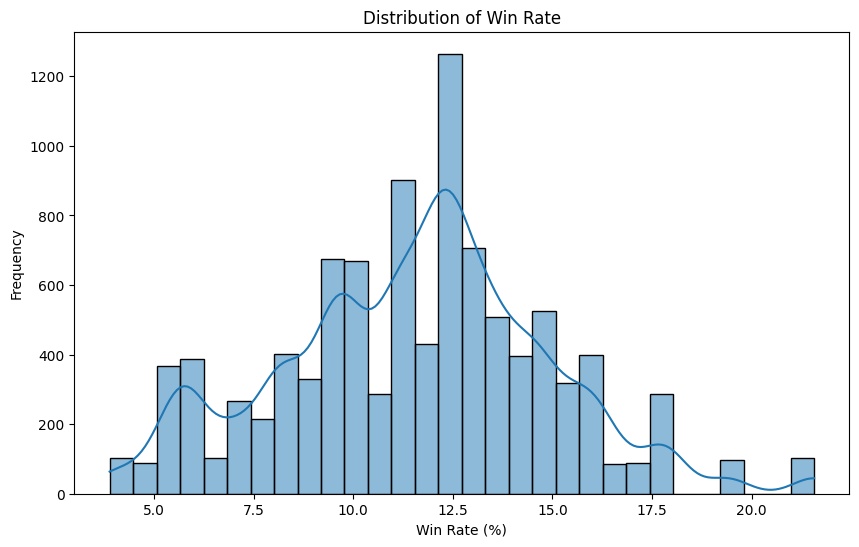

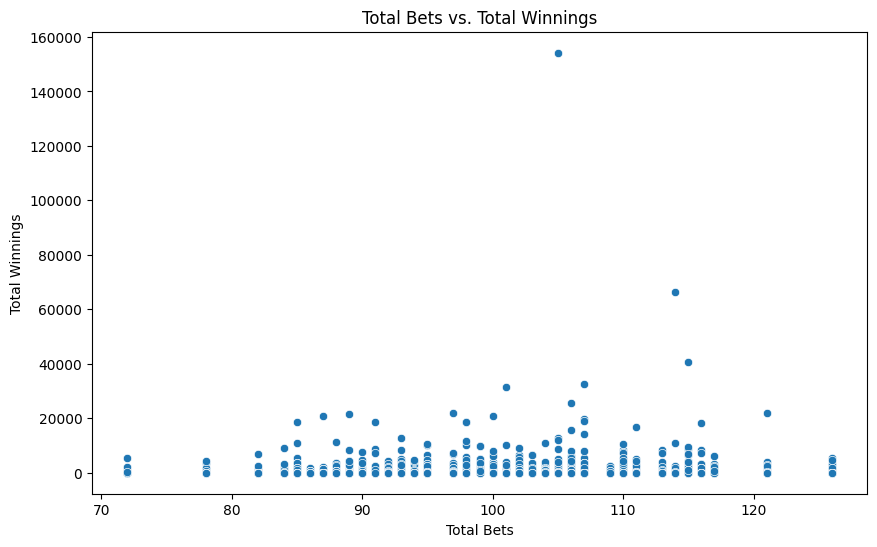

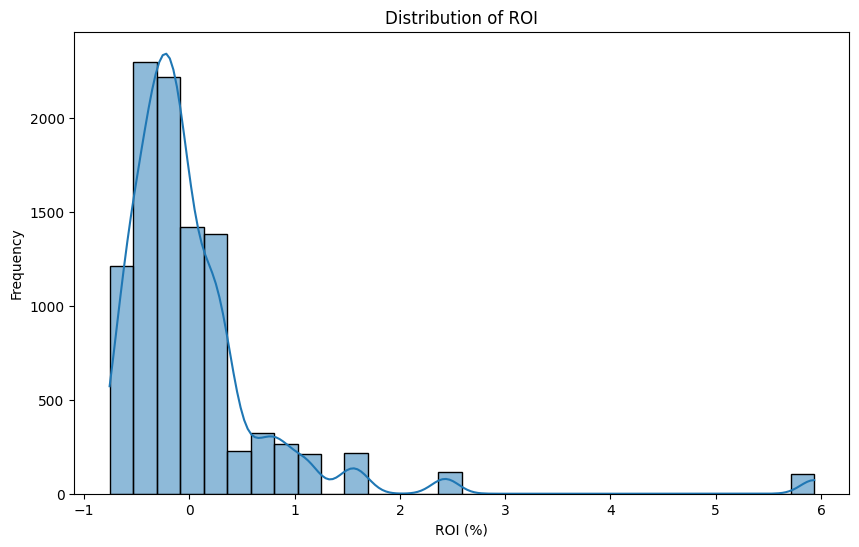

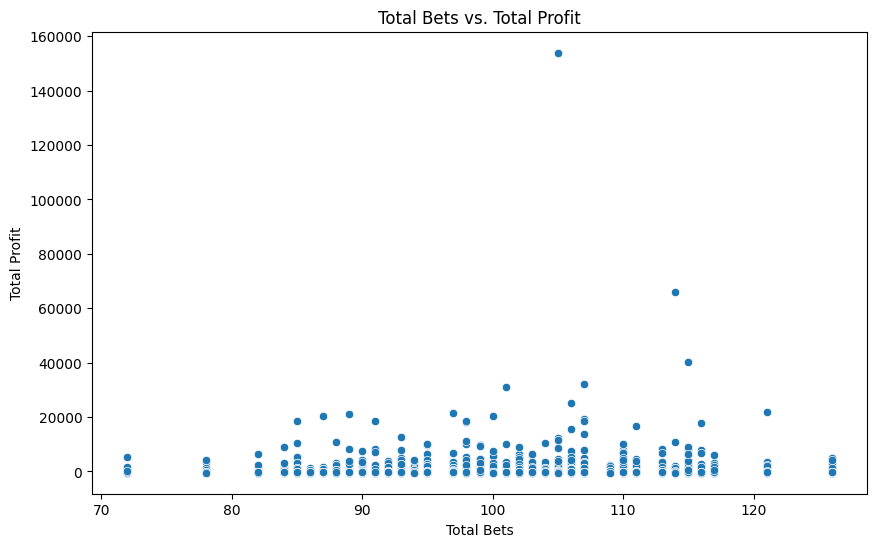

In [115]:
# Plot: Distribution of Win Rate
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Win_Rate'], bins=30, kde=True)
plt.title('Distribution of Win Rate')
plt.xlabel('Win Rate (%)')
plt.ylabel('Frequency')
plt.savefig('win_rate_distribution.png')
plt.show()

# Plot: Total Bets vs. Total Winnings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mock, x='Total_Bets', y='Total_Winnings')
plt.title('Total Bets vs. Total Winnings')
plt.xlabel('Total Bets')
plt.ylabel('Total Winnings')
plt.savefig('total_bets_vs_total_winnings.png')
plt.show()

# Plot: ROI Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['ROI'], bins=30, kde=True)
plt.title('Distribution of ROI')
plt.xlabel('ROI (%)')
plt.ylabel('Frequency')
plt.savefig('roi_distribution.png')
plt.show()

# Plot: Total Bets vs. Total Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mock, x='Total_Bets', y='Profit')
plt.title('Total Bets vs. Total Profit')
plt.xlabel('Total Bets')
plt.ylabel('Total Profit')
plt.savefig('total_bets_vs_total_profit.png')
plt.show()

In [116]:
# Export the enhanced DataFrame to CSV
df_mock.to_csv('enhanced_mock_betting_data.csv', index=False)
print("Enhanced data exported to 'enhanced_mock_betting_data.csv'")

Enhanced data exported to 'enhanced_mock_betting_data.csv'


In [117]:

# Number of mock entries
num_entries = 10000

# Generate random data
np.random.seed(42)  # For reproducibility
user_ids = np.random.randint(1, 101, num_entries)
num_bets = np.random.randint(2, 7, num_entries)  # Number of bets in each parlay (2 to 6)
bet_amounts = np.round(np.random.uniform(10, 500, num_entries), 2)

# Create a DataFrame
df_mock = pd.DataFrame({
    'User_ID': user_ids,
    'Num_Bets': num_bets,
    'Bet_Amount': bet_amounts
})

# Function to generate random American odds from a predefined set
def generate_random_odds(num_bets):
    predefined_odds = [-500, -450, -400, -200, -150, -120, -105, 100, 105, 110, 115, 180, 220, 300, 400, 500]
    strategy = np.random.choice(['all_favorites', 'all_underdogs', 'mix'], p=[0.2, 0.2, 0.6])
    
    if strategy == 'all_favorites':
        odds = np.random.choice([odd for odd in predefined_odds if odd < 0], num_bets)
    elif strategy == 'all_underdogs':
        odds = np.random.choice([odd for odd in predefined_odds if odd > 0], num_bets)
    else:  # mix
        odds = np.random.choice(predefined_odds, num_bets)
    
    return odds

# Apply the function to generate random odds for each entry
df_mock['Odds'] = df_mock['Num_Bets'].apply(generate_random_odds)

# Function to convert American odds to implied probability
def american_to_implied_probability(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Apply the function to calculate implied probabilities for each bet
df_mock['Implied_Probabilities'] = df_mock['Odds'].apply(lambda x: [american_to_implied_probability(odd) for odd in x])

# Function to simulate bet outcomes based on implied probabilities
def simulate_outcomes(implied_probabilities):
    outcomes = []
    for prob in implied_probabilities:
        outcome = np.random.choice(['Win', 'Loss'], p=[prob, 1 - prob])
        outcomes.append(outcome)
    return outcomes

# Apply the function to simulate outcomes for each entry
df_mock['Outcomes'] = df_mock['Implied_Probabilities'].apply(simulate_outcomes)

# Function to calculate payouts based on the number of bets and wins
def calculate_payout(row):
    num_bets = row['Num_Bets']
    bet_amount = row['Bet_Amount']
    outcomes = row['Outcomes']
    
    num_wins = np.sum(np.array(outcomes) == 'Win')
    
    if num_bets == 6:
        if num_wins == 6:
            return bet_amount * 25
        elif num_wins == 5:
            return bet_amount * 2
        elif num_wins == 4:
            return bet_amount * 0.4
    elif num_bets == 5:
        if num_wins == 5:
            return bet_amount * 10
        elif num_wins == 4:
            return bet_amount * 2
        elif num_wins == 3:
            return bet_amount * 0.4
    elif num_bets == 4:
        if num_wins == 4:
            return bet_amount * 5
        elif num_wins == 3:
            return bet_amount * 1.5
    elif num_bets == 3:
        if num_wins == 3:
            return bet_amount * 2.25
        elif num_wins == 2:
            return bet_amount * 1.25
    return 0

# Apply the function to calculate payouts for each entry
df_mock['Payout'] = df_mock.apply(calculate_payout, axis=1)

# Calculate profit
df_mock['Profit'] = df_mock['Payout'] - df_mock['Bet_Amount']

# Display the first few rows to verify
print(df_mock.head(10))

   User_ID  Num_Bets  Bet_Amount                                  Odds  \
0       52         6       81.33  [-120, -120, -150, -450, -150, -450]   
1       93         6      417.26      [105, 300, -120, 100, 110, -400]   
2       15         2      180.86                           [-200, 180]   
3       72         5      206.07        [-400, -200, -150, -500, -500]   
4       61         3      448.09                       [115, 500, 180]   
5       21         5      253.35        [-450, -120, -150, -120, -450]   
6       83         5      276.68             [110, 300, 110, 105, 400]   
7       87         5      478.68           [-450, 100, 105, -200, 400]   
8       75         2      444.50                            [105, 180]   
9       75         2       93.04                           [110, -400]   

                               Implied_Probabilities  \
0  [0.5454545454545454, 0.5454545454545454, 0.6, ...   
1  [0.4878048780487805, 0.25, 0.5454545454545454,...   
2          [0.666

In [118]:
# Calculate total bets, total wins, total losses, average bet amount, and overall ROI for each user
user_summary = df_mock.groupby('User_ID').agg(
    Total_Bets=('Bet_Amount', 'count'),
    Total_Wins=('Payout', lambda x: (x > 0).sum()),
    Total_Losses=('Payout', lambda x: (x == 0).sum()),
    Total_Amount_Bet=('Bet_Amount', 'sum'),
    Total_Payout=('Payout', 'sum'),
    Average_Bet_Amount=('Bet_Amount', 'mean'),
    ROI=('Profit', lambda x: (x.sum() / df_mock['Bet_Amount'].sum()) * 100)
).reset_index()

# Display the user summary
print(user_summary.head())

   User_ID  Total_Bets  Total_Wins  Total_Losses  Total_Amount_Bet  \
0        1          97          35            62          27256.65   
1        2         110          47            63          28384.21   
2        3          99          34            65          27520.74   
3        4         103          38            65          25456.06   
4        5          87          28            59          24612.14   

   Total_Payout  Average_Bet_Amount       ROI  
0    15889.8060          280.996392 -0.438066  
1    40153.9325          258.038273  0.453593  
2    14896.2780          277.987273 -0.486533  
3    12250.8470          247.146214 -0.508915  
4    10865.9965          282.898161 -0.529762  


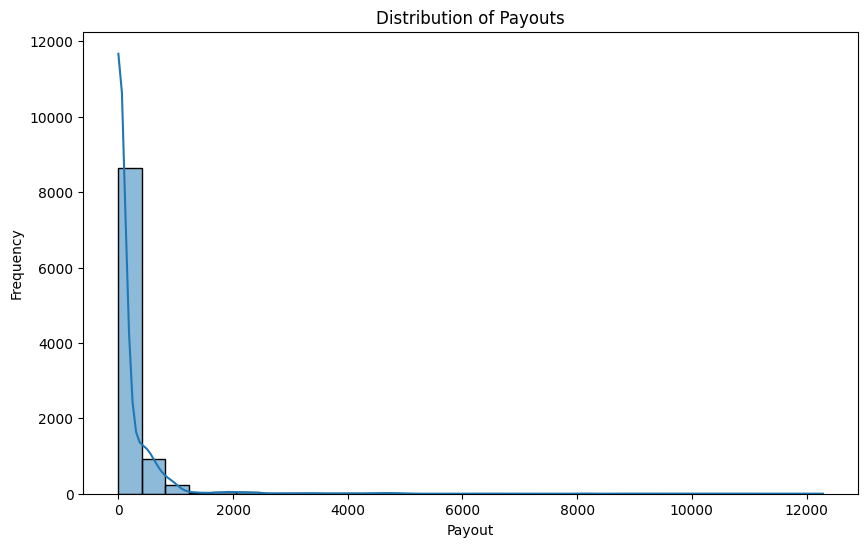

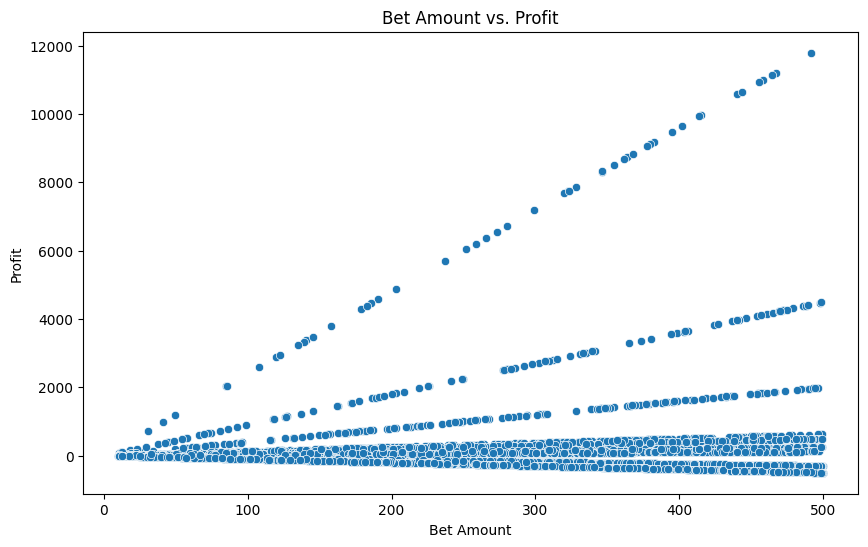

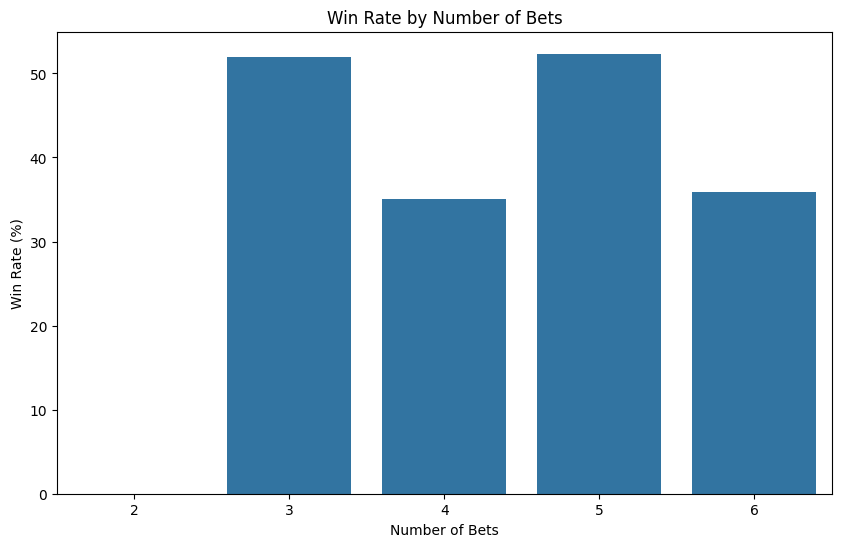

In [119]:


# Histogram of Payouts
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Payout'], bins=30, kde=True)
plt.title('Distribution of Payouts')
plt.xlabel('Payout')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot: Bet Amount vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mock, x='Bet_Amount', y='Profit')
plt.title('Bet Amount vs. Profit')
plt.xlabel('Bet Amount')
plt.ylabel('Profit')
plt.show()

# Bar Chart: Win Rate by Number of Bets
win_rate_by_bets = df_mock.groupby('Num_Bets').agg(
    Win_Rate=('Payout', lambda x: (x > 0).mean() * 100)
).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=win_rate_by_bets, x='Num_Bets', y='Win_Rate')
plt.title('Win Rate by Number of Bets')
plt.xlabel('Number of Bets')
plt.ylabel('Win Rate (%)')
plt.show()

In [120]:
# Export the enhanced DataFrame to CSV
df_mock.to_csv('prize_picks_payouts.csv', index=False)
print("Enhanced data exported to 'prized_picks_payouts.csv'")

Enhanced data exported to 'prized_picks_payouts.csv'


In [121]:
# Calculate win rate by number of bets
win_rate_by_bets = df_mock.groupby('Num_Bets').agg(
    Total_Bets=('Bet_Amount', 'count'),
    Total_Wins=('Payout', lambda x: (x > 0).sum()),
    Win_Rate=('Payout', lambda x: (x > 0).mean() * 100)
).reset_index()

# Display the win rate by number of bets
print(win_rate_by_bets)

   Num_Bets  Total_Bets  Total_Wins   Win_Rate
0         2        2021           0   0.000000
1         3        2047        1064  51.978505
2         4        1935         679  35.090439
3         5        1983        1038  52.344932
4         6        2014         724  35.948361


This is the data we are using in the csvs to find trends, patterns, and make decisions based on the data.  I changed it from seed 42 to 43 because seed 42 had 0 wins for 2 bets, so I wanted to get a better distribution and seed 43 did that.

I also wanted to make sure the payouts are similar to PrizePicks payouts as far as getting 3/5, 4/6 etc, and see what is going on with that data.

I want to export this data to a csv after making decisions in the data frame, but for my current level of skills I see the numbers in Google sheets a tad better.  I want to manipulate enough columns in Google sheets that I will upload into PowerBI making a dashboard.

Total Revenue from Losing Bets: 1397028.3480000002
Total Payouts: 1836737.62875
Casino Net Revenue: -439709.2807499997


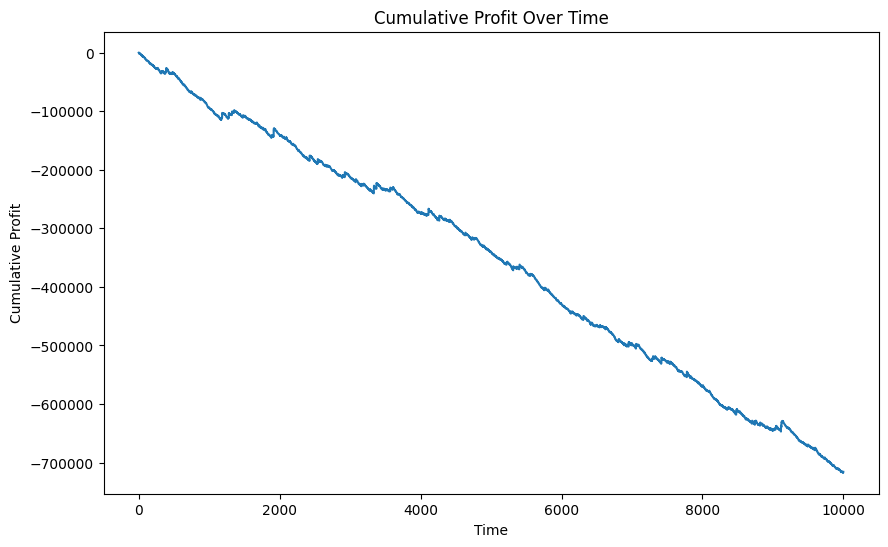

Forecasted Profit: -715771.6112500001
Actual Profit: -715771.6112500001
Variance: 0.0
Total Wins: 20303
Total Losses: 19846
Enhanced data exported to 'prize_pick_practice1.csv'


In [122]:
import pandas as pd
import numpy as np

# Number of mock entries
num_entries = 10000

# Generate random data
np.random.seed(43)  # For reproducibility
user_ids = np.random.randint(1, 101, num_entries)
num_bets = np.random.randint(2, 7, num_entries)  # Number of bets in each parlay (2 to 6)
bet_amounts = np.round(np.random.uniform(10, 500, num_entries), 2)

# Create a DataFrame
df_mock = pd.DataFrame({
    'User_ID': user_ids,
    'Num_Bets': num_bets,
    'Bet_Amount': bet_amounts
})

# Function to generate random American odds from a predefined set
def generate_random_odds(num_bets):
    predefined_odds = [-500, -450, -400, -200, -150, -120, -105, 100, 105, 110, 115, 180, 220, 300, 400, 500]
    strategy = np.random.choice(['all_favorites', 'all_underdogs', 'mix'], p=[0.1, 0.1, 0.8])
    
    if strategy == 'all_favorites':
        odds = np.random.choice([odd for odd in predefined_odds if odd < 0], num_bets)
    elif strategy == 'all_underdogs':
        odds = np.random.choice([odd for odd in predefined_odds if odd > 0], num_bets)
    else:  # mix
        odds = np.random.choice(predefined_odds, num_bets)
    
    return odds

# Apply the function to generate random odds for each entry
df_mock['Odds'] = df_mock['Num_Bets'].apply(generate_random_odds)

# Function to convert American odds to implied probability
def american_to_implied_probability(odds):
    if odds > 0:
        return 100 / (odds + 100)
    else:
        return abs(odds) / (abs(odds) + 100)

# Apply the function to calculate implied probabilities for each bet
df_mock['Implied_Probabilities'] = df_mock['Odds'].apply(lambda x: [american_to_implied_probability(odd) for odd in x])

# Function to calculate combined implied probability and combined odds
def calculate_combined_odds(implied_probabilities):
    combined_probability = np.prod(implied_probabilities)
    combined_odds = 1 / combined_probability if combined_probability != 0 else np.inf
    return combined_probability, combined_odds

# Apply the function to calculate combined implied probability and combined odds
df_mock[['Combined_Probability', 'Combined_Odds']] = df_mock['Implied_Probabilities'].apply(lambda x: pd.Series(calculate_combined_odds(x)))

# Function to calculate the vig
def calculate_vig(implied_probabilities):
    total_implied_probability = sum(implied_probabilities)
    vig = total_implied_probability - 1
    return vig

# Apply the function to calculate the vig for each entry
df_mock['Vig'] = df_mock['Implied_Probabilities'].apply(calculate_vig)

# Function to simulate bet outcomes based on implied probabilities
def simulate_outcomes(implied_probabilities):
    outcomes = []
    for prob in implied_probabilities:
        outcome = np.random.choice(['Win', 'Loss'], p=[prob, 1 - prob])
        outcomes.append(outcome)
    return outcomes

# Apply the function to simulate outcomes for each entry
df_mock['Outcomes'] = df_mock['Implied_Probabilities'].apply(simulate_outcomes)

# Calculate the casino's commission as 10% of the bet amount
df_mock['Commission'] = df_mock['Bet_Amount'] * 0.10

# Calculate the effective bet amount after commission
df_mock['Effective_Bet_Amount'] = df_mock['Bet_Amount'] - df_mock['Commission']

# Function to calculate payouts based on the number of bets and wins
def calculate_payout(row):
    num_bets = row['Num_Bets']
    effective_bet_amount = row['Effective_Bet_Amount']
    outcomes = row['Outcomes']
    
    num_wins = np.sum(np.array(outcomes) == 'Win')
    
    if num_bets == 6:
        if num_wins == 6:
            return effective_bet_amount * 25
        elif num_wins == 5:
            return effective_bet_amount * 2
        elif num_wins == 4:
            return effective_bet_amount * 0.4
    elif num_bets == 5:
        if num_wins == 5:
            return effective_bet_amount * 10
        elif num_wins == 4:
            return effective_bet_amount * 2
        elif num_wins == 3:
            return effective_bet_amount * 0.4
    elif num_bets == 4:
        if num_wins == 4:
            return effective_bet_amount * 5
        elif num_wins == 3:
            return effective_bet_amount * 1.5
    elif num_bets == 3:
        if num_wins == 3:
            return effective_bet_amount * 2.25
        elif num_wins == 2:
            return effective_bet_amount * 1.25
    elif num_bets == 2:
        if num_wins == 2:
            return effective_bet_amount * 3
    return 0

# Apply the function to calculate payouts for each entry
df_mock['Payout'] = df_mock.apply(calculate_payout, axis=1)

# Calculate profit
df_mock['Profit'] = df_mock['Payout'] - df_mock['Bet_Amount']

# Calculate the net profit for the sportsbook
df_mock['Net_Profit'] = df_mock.apply(lambda row: row['Bet_Amount'] - row['Payout'] - row['Commission'] if row['Payout'] == 0 else -row['Payout'] - row['Commission'], axis=1)

# Calculate the casino's total revenue from losing bets
total_revenue_from_losing_bets = df_mock[df_mock['Payout'] == 0]['Effective_Bet_Amount'].sum()

# Calculate the casino's total payouts
total_payouts = df_mock['Payout'].sum()

# Calculate the casino's net revenue
casino_net_revenue = total_revenue_from_losing_bets - total_payouts

# Display the results
print(f"Total Revenue from Losing Bets: {total_revenue_from_losing_bets}")
print(f"Total Payouts: {total_payouts}")
print(f"Casino Net Revenue: {casino_net_revenue}")

# Example of simple forecasting using historical data
df_mock['Cumulative_Profit'] = df_mock['Profit'].cumsum()

# Plot cumulative profit over time
plt.figure(figsize=(10, 6))
plt.plot(df_mock.index, df_mock['Cumulative_Profit'])
plt.title('Cumulative Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.show()

# Example of variance analysis
forecasted_profit = df_mock['Profit'].mean() * len(df_mock)
actual_profit = df_mock['Profit'].sum()
variance = actual_profit - forecasted_profit

print(f"Forecasted Profit: {forecasted_profit}")
print(f"Actual Profit: {actual_profit}")
print(f"Variance: {variance}")

# Analyze the distribution of wins and losses
win_counts = df_mock['Outcomes'].apply(lambda x: np.sum(np.array(x) == 'Win'))
loss_counts = df_mock['Outcomes'].apply(lambda x: np.sum(np.array(x) == 'Loss'))

# Display the distribution of wins and losses
print(f"Total Wins: {win_counts.sum()}")
print(f"Total Losses: {loss_counts.sum()}")

# Export the enhanced DataFrame to CSV
df_mock.to_csv('prize_pick_practice1.csv', index=False)
print("Enhanced data exported to 'prize_pick_practice1.csv'")

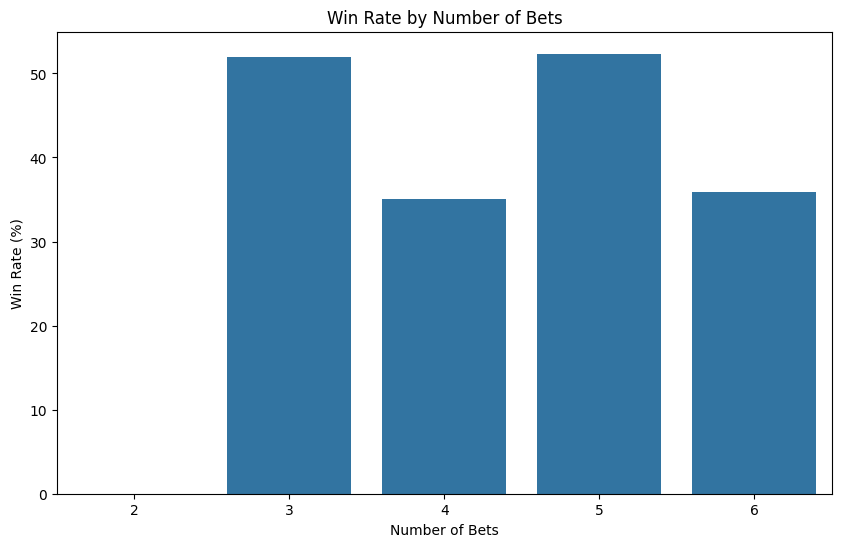

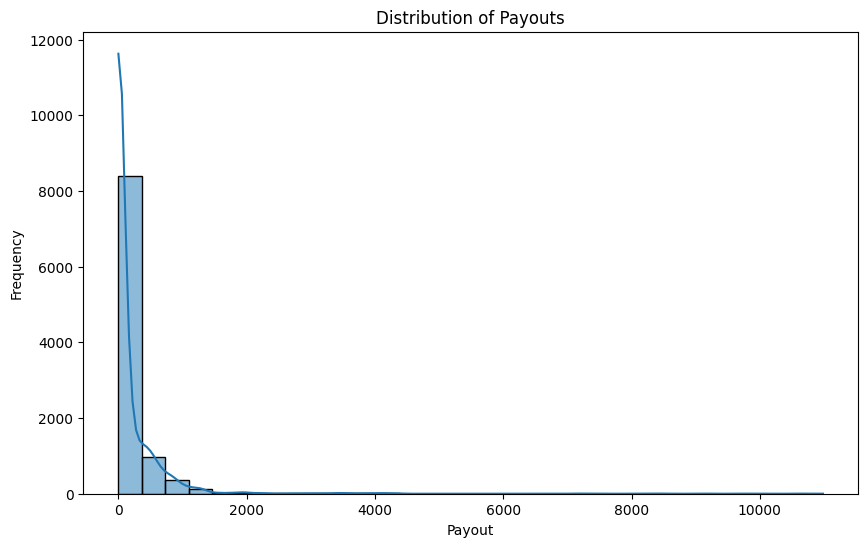

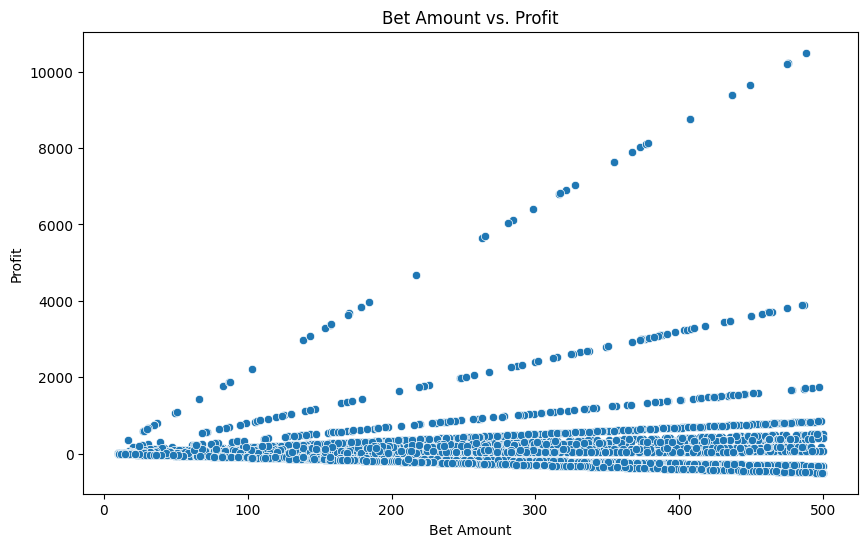

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Chart: Win Rate by Number of Bets
plt.figure(figsize=(10, 6))
sns.barplot(data=win_rate_by_bets, x='Num_Bets', y='Win_Rate')
plt.title('Win Rate by Number of Bets')
plt.xlabel('Number of Bets')
plt.ylabel('Win Rate (%)')
plt.show()

# Histogram of Payouts
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Payout'], bins=30, kde=True)
plt.title('Distribution of Payouts')
plt.xlabel('Payout')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot: Bet Amount vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mock, x='Bet_Amount', y='Profit')
plt.title('Bet Amount vs. Profit')
plt.xlabel('Bet Amount')
plt.ylabel('Profit')
plt.show()

In [124]:
# Calculate win rate by number of bets
win_rate_by_bets = df_mock.groupby('Num_Bets').agg(
    Total_Bets=('Bet_Amount', 'count'),
    Total_Wins=('Payout', lambda x: (x > 0).sum()),
    Win_Rate=('Payout', lambda x: (x > 0).mean() * 100)
).reset_index()

# Display the win rate by number of bets
print(win_rate_by_bets)

   Num_Bets  Total_Bets  Total_Wins   Win_Rate
0         2        1930         495  25.647668
1         3        2059        1027  49.878582
2         4        1951         651  33.367504
3         5        2052        1038  50.584795
4         6        2008         748  37.250996


C:\Users\Mitch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


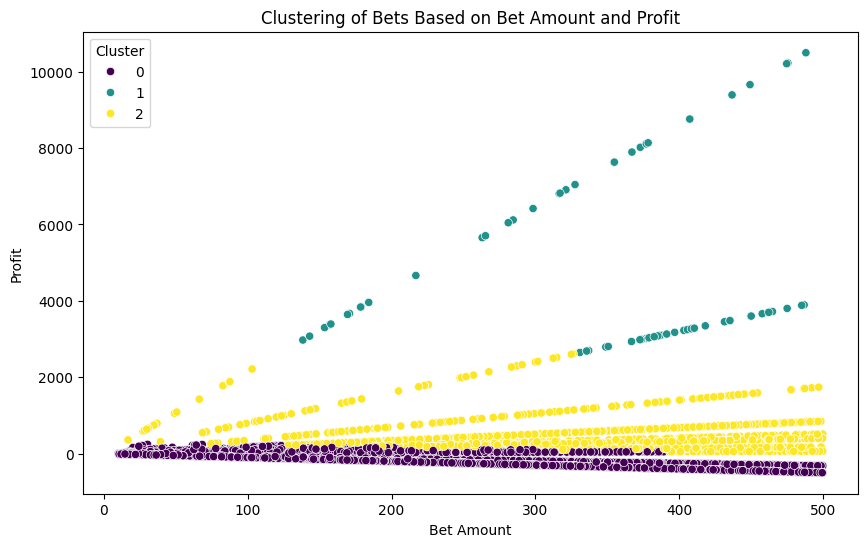

In [125]:
# Example of clustering analysis
from sklearn.cluster import KMeans

# Prepare data for clustering
X = df_mock[['Bet_Amount', 'Payout', 'Profit']]

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_mock['Cluster'] = kmeans.fit_predict(X)

# Visualization of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mock, x='Bet_Amount', y='Profit', hue='Cluster', palette='viridis')
plt.title('Clustering of Bets Based on Bet Amount and Profit')
plt.xlabel('Bet Amount')
plt.ylabel('Profit')
plt.show()

In [126]:
# Calculate the correlation matrix
correlation_matrix = df_mock[['Num_Bets', 'Bet_Amount', 'Effective_Bet_Amount', 'Payout', 'Profit', 'Net_Profit']].corr()

# Display the correlation matrix
print(correlation_matrix)

                      Num_Bets  Bet_Amount  Effective_Bet_Amount    Payout  \
Num_Bets              1.000000    0.004128              0.004128  0.020008   
Bet_Amount            0.004128    1.000000              1.000000  0.177169   
Effective_Bet_Amount  0.004128    1.000000              1.000000  0.177169   
Payout                0.020008    0.177169              0.177169  1.000000   
Profit                0.019206   -0.077824             -0.077824  0.967407   
Net_Profit           -0.030228   -0.042096             -0.042096 -0.970950   

                        Profit  Net_Profit  
Num_Bets              0.019206   -0.030228  
Bet_Amount           -0.077824   -0.042096  
Effective_Bet_Amount -0.077824   -0.042096  
Payout                0.967407   -0.970950  
Profit                1.000000   -0.972734  
Net_Profit           -0.972734    1.000000  


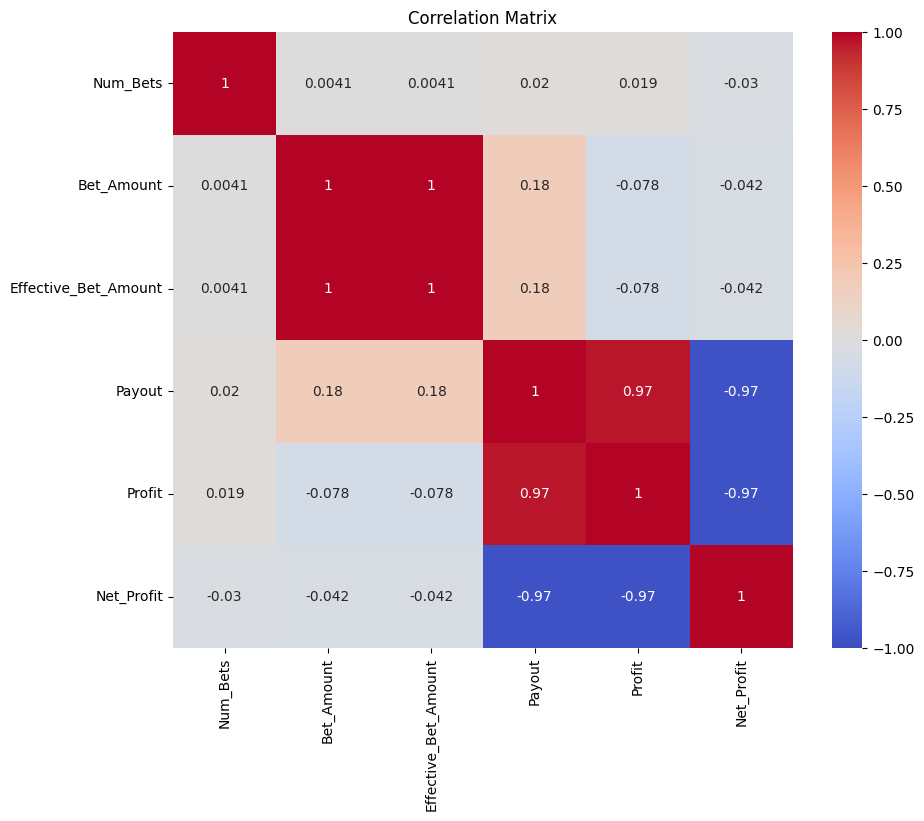

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [128]:
# Segment the data by number of bets
small_bets = df_mock[df_mock['Num_Bets'] <= 3]
large_bets = df_mock[df_mock['Num_Bets'] > 3]

# Calculate summary statistics for each segment
small_bets_summary = small_bets.describe()
large_bets_summary = large_bets.describe()

print("Summary for Small Bets:")
print(small_bets_summary)

print("\nSummary for Large Bets:")
print(large_bets_summary)

Summary for Small Bets:
           User_ID     Num_Bets   Bet_Amount  Combined_Probability  \
count  3989.000000  3989.000000  3989.000000           3989.000000   
mean     50.360742     2.516169   254.176723              0.195257   
std      28.845957     0.499801   140.833452              0.150367   
min       1.000000     2.000000    10.010000              0.004630   
25%      26.000000     2.000000   133.630000              0.077262   
50%      51.000000     3.000000   251.480000              0.152439   
75%      75.000000     3.000000   373.410000              0.279379   
max     100.000000     3.000000   499.950000              0.694444   

       Combined_Odds          Vig   Commission  Effective_Bet_Amount  \
count    3989.000000  3989.000000  3989.000000           3989.000000   
mean       11.651341     0.265745    25.417672            228.759051   
std        15.771369     0.439656    14.083345            126.750107   
min         1.440000    -0.666667     1.001000           

In [129]:
from scipy.stats import ttest_ind

# Perform t-test to compare profits between small and large bets
t_stat, p_value = ttest_ind(small_bets['Profit'], large_bets['Profit'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -1.4793229314574405
P-value: 0.13908553259116377


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Prepare the data for modeling
X = df_mock[['Num_Bets', 'Bet_Amount', 'Effective_Bet_Amount']]
y = df_mock['Profit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 593433.723778078


In [131]:
# Create new features
df_mock['Bet_Amount_Squared'] = df_mock['Bet_Amount'] ** 2
df_mock['Num_Bets_Squared'] = df_mock['Num_Bets'] ** 2

# Prepare the data for modeling
X = df_mock[['Num_Bets', 'Bet_Amount', 'Effective_Bet_Amount', 'Bet_Amount_Squared', 'Num_Bets_Squared']]
y = df_mock['Profit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

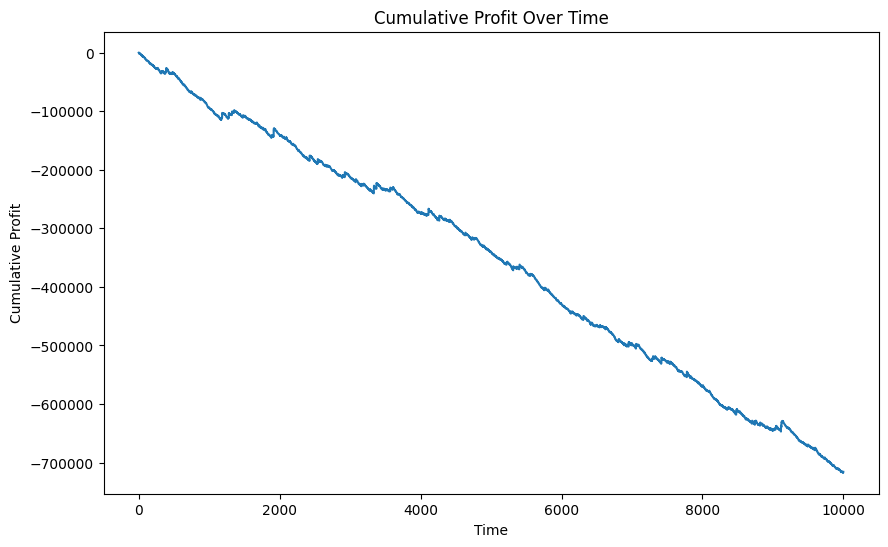

Forecasted Profit: -715771.6112500001
Actual Profit: -715771.6112500001
Variance: 0.0


In [132]:
# Example of simple forecasting using historical data
df_mock['Cumulative_Profit'] = df_mock['Profit'].cumsum()

# Plot cumulative profit over time
plt.figure(figsize=(10, 6))
plt.plot(df_mock.index, df_mock['Cumulative_Profit'])
plt.title('Cumulative Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.show()

# Example of variance analysis
forecasted_profit = df_mock['Profit'].mean() * len(df_mock)
actual_profit = df_mock['Profit'].sum()
variance = actual_profit - forecasted_profit

print(f"Forecasted Profit: {forecasted_profit}")
print(f"Actual Profit: {actual_profit}")
print(f"Variance: {variance}")

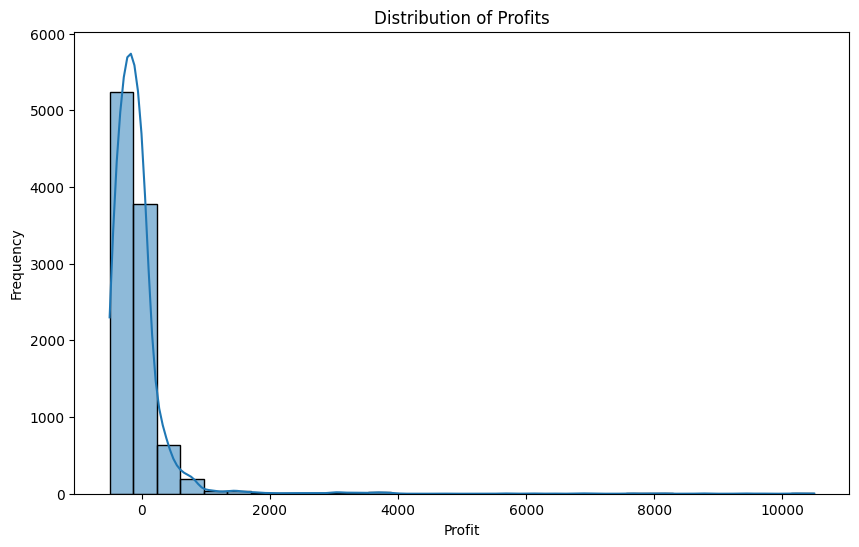

            User_ID      Num_Bets    Bet_Amount  Combined_Probability  \
count  10000.000000  10000.000000  10000.000000          10000.000000   
mean      50.445900      4.014900    255.250924              0.104462   
std       29.018747      1.409353    141.090852              0.128905   
min        1.000000      2.000000     10.010000              0.000058   
25%       25.750000      3.000000    134.900000              0.014586   
50%       50.000000      4.000000    252.645000              0.050813   
75%       76.000000      5.000000    376.830000              0.145349   
max      100.000000      6.000000    500.000000              0.694444   

       Combined_Odds           Vig    Commission  Effective_Bet_Amount  \
count   10000.000000  10000.000000  10000.000000          10000.000000   
mean      102.164677      1.014825     25.525092            229.725832   
std       365.782187      0.858088     14.109085            126.981767   
min         1.440000     -0.666667      1.0010

In [133]:
# Example of automating data analysis
def automate_analysis(df):
    # Calculate summary statistics
    summary_stats = df.describe()
    
    # Generate visualizations
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Profit'], bins=30, kde=True)
    plt.title('Distribution of Profits')
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    plt.show()
    
    return summary_stats

# Run the automated analysis
summary_stats = automate_analysis(df_mock)
print(summary_stats)

Total Revenue from Losing Bets: 1397028.3480000002
Total Payouts: 1836737.62875
Casino Net Revenue: -439709.2807499997


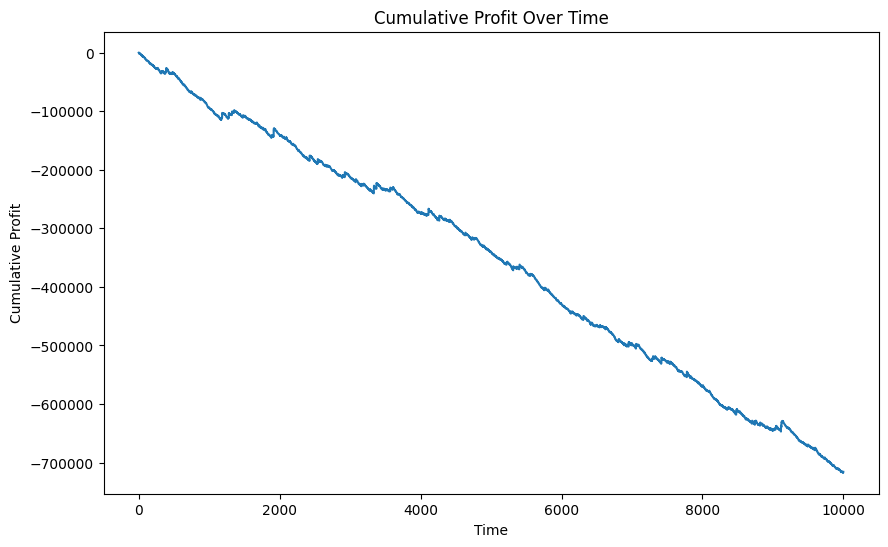

Forecasted Profit: -715771.6112500001
Actual Profit: -715771.6112500001
Variance: 0.0


In [134]:
# Apply the function to calculate payouts for each entry
df_mock['Payout'] = df_mock.apply(calculate_payout, axis=1)

# Calculate profit
df_mock['Profit'] = df_mock['Payout'] - df_mock['Bet_Amount']

# Calculate the net profit for the sportsbook
df_mock['Net_Profit'] = df_mock.apply(lambda row: row['Bet_Amount'] - row['Payout'] - row['Commission'] if row['Payout'] == 0 else -row['Payout'] - row['Commission'], axis=1)

# Calculate the casino's total revenue from losing bets
total_revenue_from_losing_bets = df_mock[df_mock['Payout'] == 0]['Effective_Bet_Amount'].sum()

# Calculate the casino's total payouts
total_payouts = df_mock['Payout'].sum()

# Calculate the casino's net revenue
casino_net_revenue = total_revenue_from_losing_bets - total_payouts

# Display the results
print(f"Total Revenue from Losing Bets: {total_revenue_from_losing_bets}")
print(f"Total Payouts: {total_payouts}")
print(f"Casino Net Revenue: {casino_net_revenue}")

# Example of simple forecasting using historical data
df_mock['Cumulative_Profit'] = df_mock['Profit'].cumsum()

# Plot cumulative profit over time
plt.figure(figsize=(10, 6))
plt.plot(df_mock.index, df_mock['Cumulative_Profit'])
plt.title('Cumulative Profit Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.show()

# Example of variance analysis
forecasted_profit = df_mock['Profit'].mean() * len(df_mock)
actual_profit = df_mock['Profit'].sum()
variance = actual_profit - forecasted_profit

print(f"Forecasted Profit: {forecasted_profit}")
print(f"Actual Profit: {actual_profit}")
print(f"Variance: {variance}")

         Total_Bets  Total_Amount_Bet  Average_Bet_Amount  Total_Profit  Wins  \
User_ID                                                                         
1               108          27864.24          258.002222   -7815.45345   230   
2               115          29012.56          252.283130  -11049.27280   233   
3                98          24264.73          247.599286    2458.66805   219   
4               100          26027.08          260.270800  -12101.47945   187   
5               114          29933.51          262.574649  -16971.38735   223   

         Losses  Win_Loss_Ratio  
User_ID                          
1           237        0.970464  
2           246        0.947154  
3           163        1.343558  
4           207        0.903382  
5           238        0.936975  


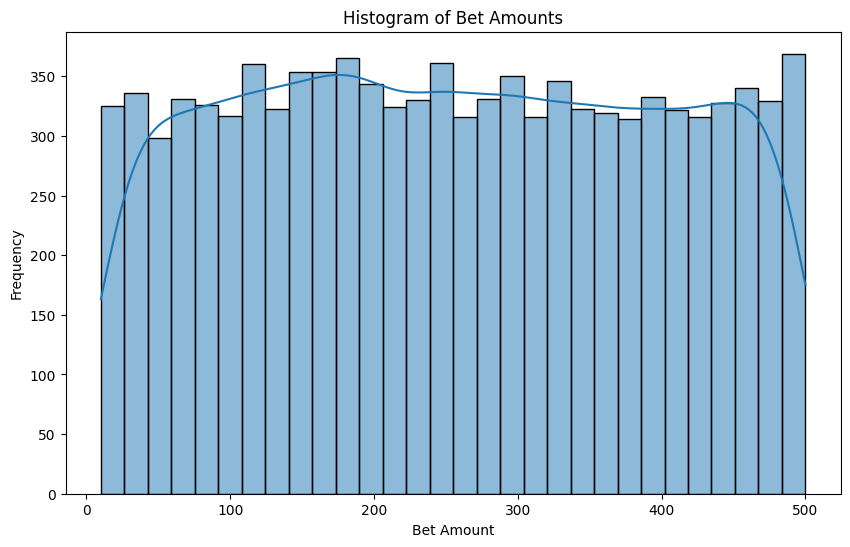

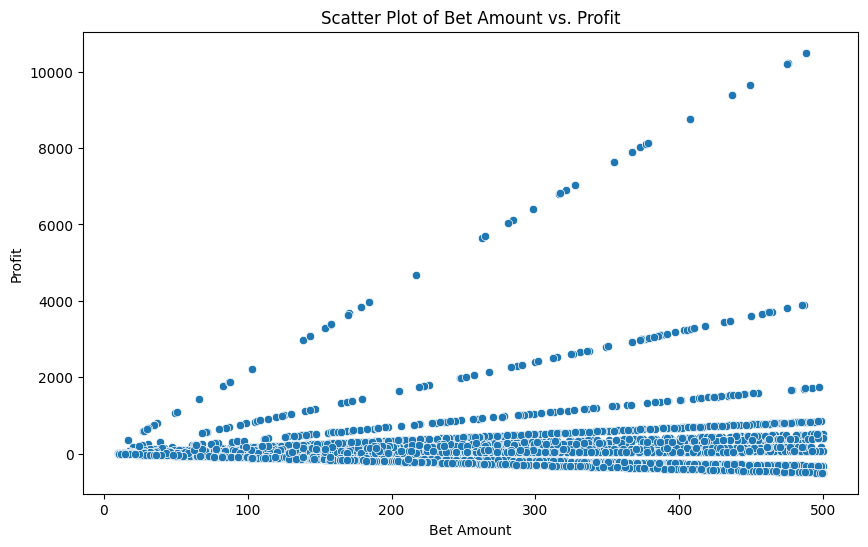

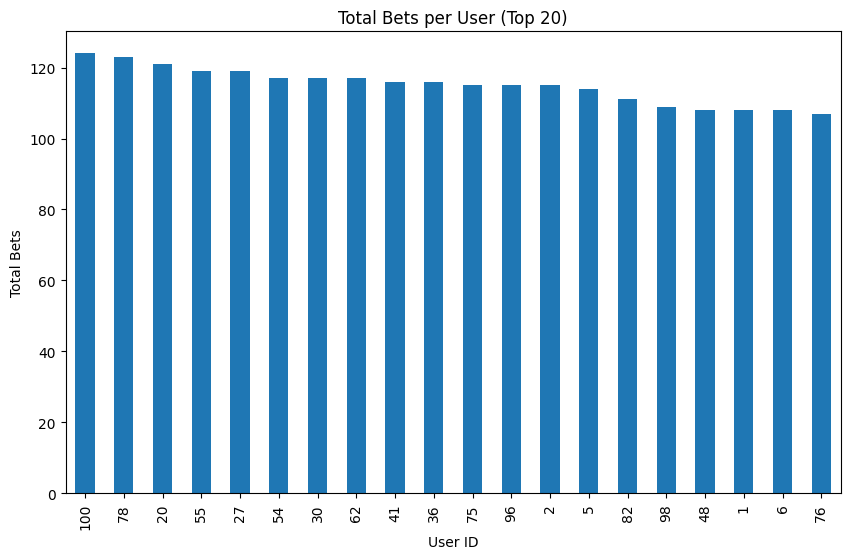

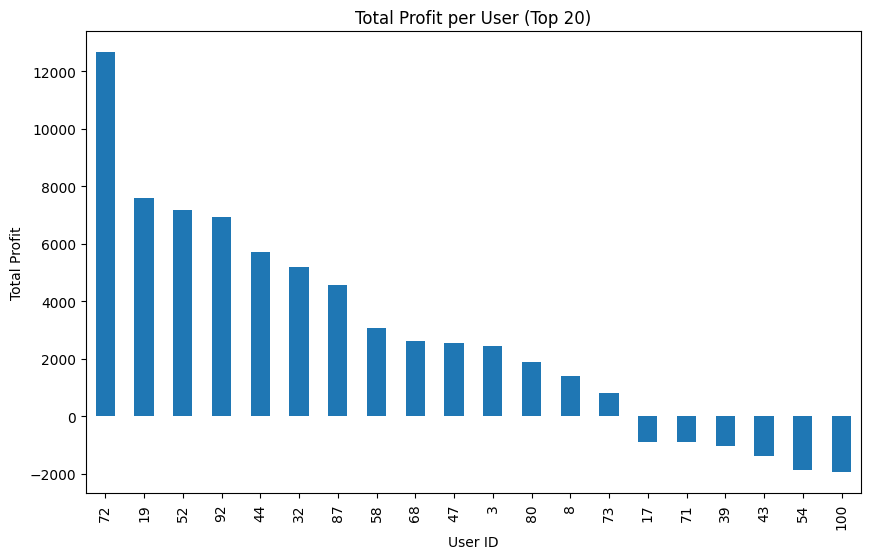

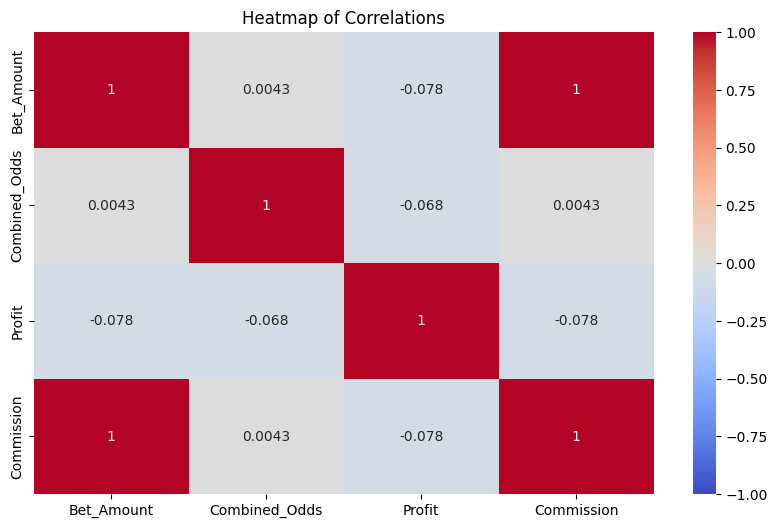

In [135]:
# Aggregate Data Analysis
# Total Bets and Total Amount Bet per User
user_aggregate = df_mock.groupby('User_ID').agg(
    Total_Bets=('User_ID', 'count'),
    Total_Amount_Bet=('Bet_Amount', 'sum'),
    Average_Bet_Amount=('Bet_Amount', 'mean'),
    Total_Profit=('Profit', 'sum'),
    Wins=('Outcomes', lambda x: sum([outcome == 'Win' for outcomes in x for outcome in outcomes])),
    Losses=('Outcomes', lambda x: sum([outcome == 'Loss' for outcomes in x for outcome in outcomes]))
)

# Calculate Win/Loss Ratio
user_aggregate['Win_Loss_Ratio'] = user_aggregate['Wins'] / user_aggregate['Losses']

# Display the aggregate data
print(user_aggregate.head())

# Visualizations
# Histogram of Bet Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Bet_Amount'], bins=30, kde=True)
plt.title('Histogram of Bet Amounts')
plt.xlabel('Bet Amount')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot of Bet Amount vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bet_Amount', y='Profit', data=df_mock)
plt.title('Scatter Plot of Bet Amount vs. Profit')
plt.xlabel('Bet Amount')
plt.ylabel('Profit')
plt.show()

# Bar Plot of Total Bets per User
plt.figure(figsize=(10, 6))
user_aggregate['Total_Bets'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Total Bets per User (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Total Bets')
plt.show()

# Bar Plot of Total Profit per User
plt.figure(figsize=(10, 6))
user_aggregate['Total_Profit'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Total Profit per User (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Total Profit')
plt.show()

# Heatmap of Correlations
plt.figure(figsize=(10, 6))
correlation_matrix = df_mock[['Bet_Amount', 'Combined_Odds', 'Profit', 'Commission']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlations')
plt.show()


Seed: 27
Total Revenue from Losing Bets: 3948005.682
Total Payouts: 5143829.98725
Total Commission: 756267.1699999999
Casino Net Revenue: -439557.1352500003
Total Wins: 31675
Total Losses: 28534

         Total_Bets  Total_Amount_Bet  Average_Bet_Amount  Total_Profit  Wins  \
User_ID                                                                         
1               147          72231.75          491.372449  -19789.20585   327   
2               132          65762.73          498.202500  -28021.34880   272   
3               150          79204.23          528.028200  -21957.72615   335   
4               156          77805.49          498.753141  -14174.22550   350   
5               147          76352.71          519.406190  -32576.21410   316   

         Losses  Win_Loss_Ratio  
User_ID                          
1           274        1.193431  
2           255        1.066667  
3           282        1.187943  
4           278        1.258993  
5           307        1.029316 

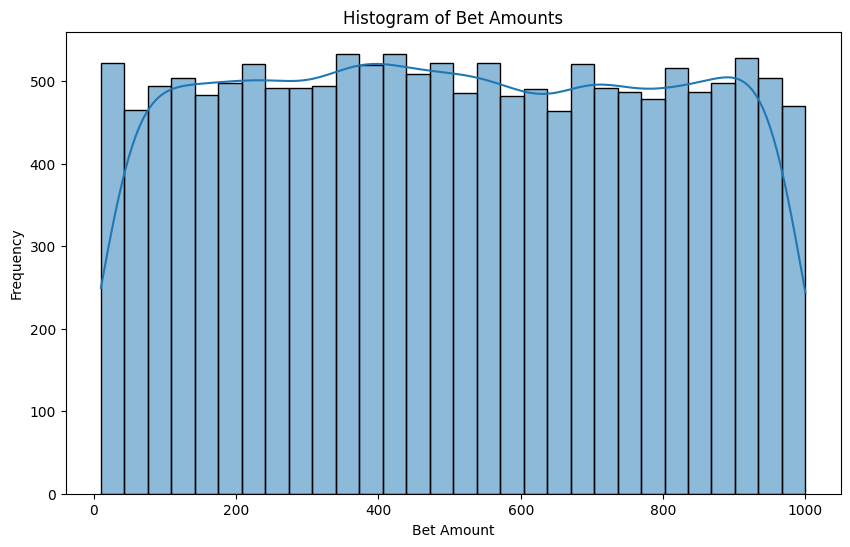

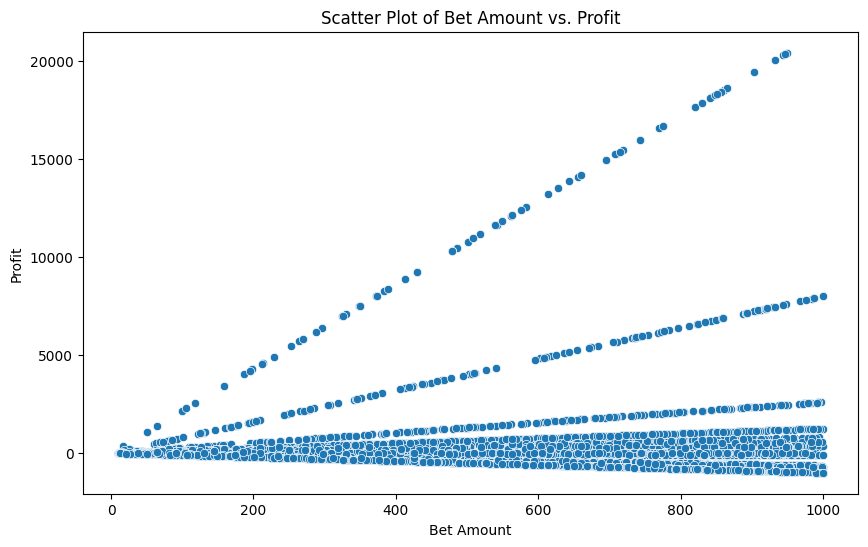

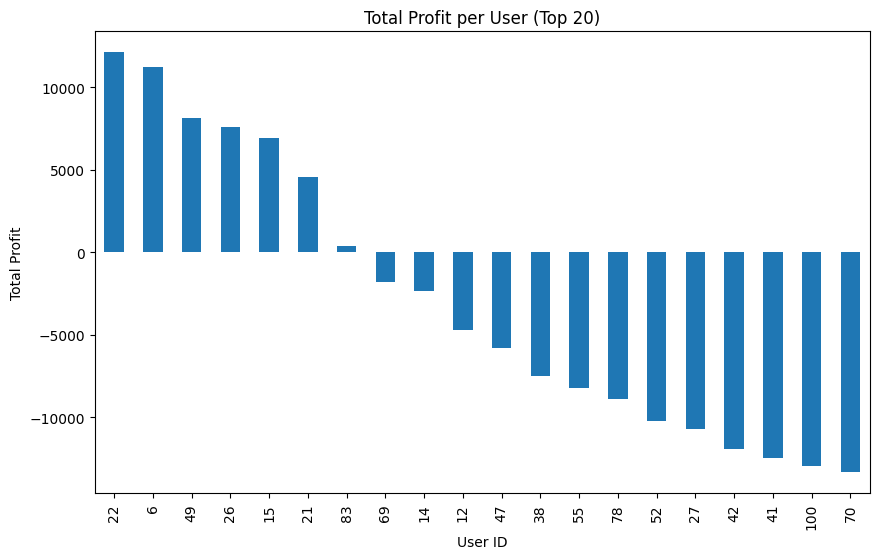

Enhanced data exported to 'prize_pick_practice_seed_27_balanced.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_simulation(seed):
    # Number of mock entries
    num_entries = 15000

    # Generate random data
    np.random.seed(seed)  # For reproducibility
    user_ids = np.random.randint(1, 101, num_entries)
    num_bets = np.random.randint(2, 7, num_entries)  # Number of bets in each parlay (2 to 6)
    bet_amounts = np.round(np.random.uniform(10, 1000, num_entries), 2)

    # Generate random dates in 2024
    start_date = pd.to_datetime('2024-01-01')
    end_date = pd.to_datetime('2024-12-31')
    dates = pd.to_datetime(np.random.randint(start_date.value // 10**9, end_date.value // 10**9, num_entries), unit='s')

    # Create a DataFrame
    df_mock = pd.DataFrame({
        'User_ID': user_ids,
        'Num_Bets': num_bets,
        'Bet_Amount': bet_amounts,
        'Date': dates
    })

    # Function to generate random American odds from a predefined set with adjusted probabilities
    def generate_random_odds(num_bets):
        predefined_odds = [-350, -250, -200, -150, -120, -110, 100, 105, 110, 115, 150, 180, 200]  # Adjusted odds
        strategy = np.random.choice(['all_favorites', 'all_underdogs', 'mix'], p=[0.05, 0.05, 0.9])  # Increased probability of mixed bets
        
        if strategy == 'all_favorites':
            odds = np.random.choice([odd for odd in predefined_odds if odd < 0], num_bets)
        elif strategy == 'all_underdogs':
            odds = np.random.choice([odd for odd in predefined_odds if odd > 0], num_bets)
        else:  # mix
            odds = np.random.choice(predefined_odds, num_bets)
        
        return odds

    # Apply the function to generate random odds for each entry
    df_mock['Odds'] = df_mock['Num_Bets'].apply(generate_random_odds)

    # Function to convert American odds to implied probability
    def american_to_implied_probability(odds):
        if odds > 0:
            return 100 / (odds + 100)
        else:
            return abs(odds) / (abs(odds) + 100)

    # Apply the function to calculate implied probabilities for each bet
    df_mock['Implied_Probabilities'] = df_mock['Odds'].apply(lambda x: [american_to_implied_probability(odd) for odd in x])

    # Function to calculate combined implied probability and combined odds
    def calculate_combined_odds(implied_probabilities):
        combined_probability = np.prod(implied_probabilities)
        combined_odds = 1 / combined_probability if combined_probability != 0 else np.inf
        return combined_probability, combined_odds

    # Apply the function to calculate combined implied probability and combined odds
    df_mock[['Combined_Probability', 'Combined_Odds']] = df_mock['Implied_Probabilities'].apply(lambda x: pd.Series(calculate_combined_odds(x)))

    # Function to calculate the vig
    def calculate_vig(implied_probabilities):
        total_implied_probability = sum(implied_probabilities)
        vig = total_implied_probability - 1
        return vig

    # Apply the function to calculate the vig for each entry
    df_mock['Vig'] = df_mock['Implied_Probabilities'].apply(calculate_vig)

    # Function to simulate bet outcomes based on implied probabilities
    def simulate_outcomes(implied_probabilities):
        outcomes = []
        for prob in implied_probabilities:
            outcome = np.random.choice(['Win', 'Loss'], p=[prob, 1 - prob])
            outcomes.append(outcome)
        return outcomes

    # Apply the function to simulate outcomes for each entry
    df_mock['Outcomes'] = df_mock['Implied_Probabilities'].apply(simulate_outcomes)

    # Calculate the casino's commission as 10% of the bet amount
    df_mock['Commission'] = df_mock['Bet_Amount'] * 0.10

    # Calculate the effective bet amount after commission
    df_mock['Effective_Bet_Amount'] = df_mock['Bet_Amount'] - df_mock['Commission']

    # Function to calculate payouts based on the number of bets and wins
    def calculate_payout(row):
        num_bets = row['Num_Bets']
        effective_bet_amount = row['Effective_Bet_Amount']
        outcomes = row['Outcomes']
        
        num_wins = np.sum(np.array(outcomes) == 'Win')
        
        if num_bets == 6:
            if num_wins == 6:
                return effective_bet_amount * 25  # Adjusted from 25
            elif num_wins == 5:
                return effective_bet_amount * 2  # Adjusted from 2
            elif num_wins == 4:
                return effective_bet_amount * 0.4  # Adjusted from 0.4
        elif num_bets == 5:
            if num_wins == 5:
                return effective_bet_amount * 10  # Adjusted from 10
            elif num_wins == 4:
                return effective_bet_amount * 1.5  # Adjusted from 2
            elif num_wins == 3:
                return effective_bet_amount * 0.3  # Adjusted from 0.4
        elif num_bets == 4:
            if num_wins == 4:
                return effective_bet_amount * 4  # Adjusted from 5
            elif num_wins == 3:
                return effective_bet_amount * 1 # Adjusted from 1.5
        elif num_bets == 3:
            if num_wins == 3:
                return effective_bet_amount * 1.75  # Adjusted from 2.25
            elif num_wins == 2:
                return effective_bet_amount * 1.1  # Adjusted from 1.25
        elif num_bets == 2:
            if num_wins == 2:
                return effective_bet_amount * 2.5  # Adjusted from 3
        return 0

    # Apply the function to calculate payouts for each entry
    df_mock['Payout'] = df_mock.apply(calculate_payout, axis=1)

    # Calculate profit
    df_mock['Profit'] = df_mock['Payout'] - df_mock['Bet_Amount']

    # Calculate the net profit for the sportsbook
    df_mock['Net_Profit'] = df_mock.apply(lambda row: row['Bet_Amount'] - row['Payout'] - row['Commission'] if row['Payout'] == 0 else -row['Payout'] - row['Commission'], axis=1)

    # Calculate the casino's total revenue from losing bets
    total_revenue_from_losing_bets = df_mock[df_mock['Payout'] == 0]['Effective_Bet_Amount'].sum()

    # Calculate the casino's total payouts
    total_payouts = df_mock['Payout'].sum()

    # Calculate the casino's total commission
    total_commission = df_mock['Commission'].sum()

    # Calculate the casino's net revenue including commission
    casino_net_revenue = total_revenue_from_losing_bets - total_payouts + total_commission

    # Calculate total wins and total losses
    total_wins = df_mock['Outcomes'].apply(lambda x: np.sum(np.array(x) == 'Win')).sum()
    total_losses = df_mock['Outcomes'].apply(lambda x: np.sum(np.array(x) == 'Loss')).sum()

    # Return the results
    return df_mock, total_revenue_from_losing_bets, total_payouts, total_commission, casino_net_revenue, total_wins, total_losses

# Run simulation for seed 27
seed = 27
df_mock, total_revenue_from_losing_bets, total_payouts, total_commission, casino_net_revenue, total_wins, total_losses = run_simulation(seed)

# Print the results
print(f"Seed: {seed}")
print(f"Total Revenue from Losing Bets: {total_revenue_from_losing_bets}")
print(f"Total Payouts: {total_payouts}")
print(f"Total Commission: {total_commission}")
print(f"Casino Net Revenue: {casino_net_revenue}")
print(f"Total Wins: {total_wins}")
print(f"Total Losses: {total_losses}")
print()

# Aggregate Data Analysis
# Total Bets and Total Amount Bet per User
user_aggregate = df_mock.groupby('User_ID').agg(
    Total_Bets=('User_ID', 'count'),
    Total_Amount_Bet=('Bet_Amount', 'sum'),
    Average_Bet_Amount=('Bet_Amount', 'mean'),
    Total_Profit=('Profit', 'sum'),
    Wins=('Outcomes', lambda x: sum([outcome == 'Win' for outcomes in x for outcome in outcomes])),
    Losses=('Outcomes', lambda x: sum([outcome == 'Loss' for outcomes in x for outcome in outcomes]))
)

# Calculate Win/Loss Ratio
user_aggregate['Win_Loss_Ratio'] = user_aggregate['Wins'] / user_aggregate['Losses']

# Display the aggregate data
print(user_aggregate.head())

# Visualizations
# Histogram of Bet Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_mock['Bet_Amount'], bins=30, kde=True)
plt.title('Histogram of Bet Amounts')
plt.xlabel('Bet Amount')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot of Bet Amount vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bet_Amount', y='Profit', data=df_mock)
plt.title('Scatter Plot of Bet Amount vs. Profit')
plt.xlabel('Bet Amount')
plt.ylabel('Profit')
plt.show()

# Bar Plot of Total Bets per User
#plt.figure(figsize=(10, 6))
#user_aggregate['Total_Bets'].sort_values(ascending=False).head(20).plot(kind='bar')
#plt.title('Total Bets per User (Top 20)')
#plt.xlabel('User ID')
#plt.ylabel('Total Bets')
#plt.show()

# Bar Plot of Total Profit per User
plt.figure(figsize=(10, 6))
user_aggregate['Total_Profit'].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Total Profit per User (Top 20)')
plt.xlabel('User ID')
plt.ylabel('Total Profit')
plt.show()

# Heatmap of Correlations
#plt.figure(figsize=(10, 6))
#correlation_matrix = df_mock[['Bet_Amount', 'Combined_Odds', 'Profit', 'Commission']].corr()
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
#plt.title('Heatmap of Correlations')
#plt.show()

# Export the enhanced DataFrame to CSV
df_mock.to_csv('prize_pick_practice_seed_27_balanced.csv', index=False)
print("Enhanced data exported to 'prize_pick_practice_seed_27_balanced.csv'")

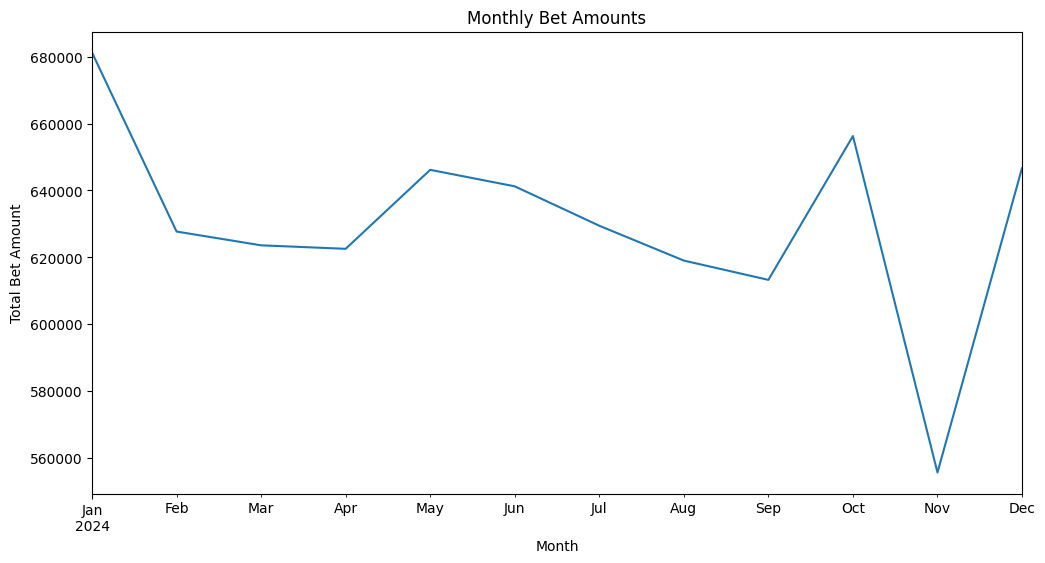

In [152]:
# Time Series Analysis of Bet Amounts
df_mock['Date'] = pd.to_datetime(df_mock['Date'])
df_mock.set_index('Date', inplace=True)
monthly_bets = df_mock['Bet_Amount'].resample('M').sum()

plt.figure(figsize=(12, 6))
monthly_bets.plot()
plt.title('Monthly Bet Amounts')
plt.xlabel('Month')
plt.ylabel('Total Bet Amount')
plt.show()

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Feature Engineering
df_mock['Win'] = df_mock['Profit'] > 0
features = df_mock[['Bet_Amount', 'Num_Bets', 'Combined_Probability']]
target = df_mock['Win']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.92      0.87      3695
        True       0.28      0.14      0.19       805

    accuracy                           0.78      4500
   macro avg       0.55      0.53      0.53      4500
weighted avg       0.73      0.78      0.75      4500



In [154]:
# Calculate total bet amount
total_bet_amount = df_mock['Bet_Amount'].sum()

# Calculate total payouts
total_payouts = df_mock['Payout'].sum()

# Calculate total commission
total_commission = total_bet_amount * 0.10

# Calculate casino net profit
casino_net_profit = total_bet_amount - total_payouts + total_commission

print(f"Total Bet Amount: {total_bet_amount}")
print(f"Total Payouts: {total_payouts}")
print(f"Total Commission: {total_commission}")
print(f"Casino Net Profit: {casino_net_profit}")

Total Bet Amount: 7562671.699999999
Total Payouts: 5143829.98725
Total Commission: 756267.1699999999
Casino Net Profit: 3175108.882749999
